In [1]:
import graph_tool.all as gt
import csv
import pickle
import numpy as np
import pandas
import math
import random
import scipy.optimize
import scipy.interpolate
import scipy.io
import h5py
import sklearn
import sklearn.metrics
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
from matplotlib import patches
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits import mplot3d
%matplotlib inline

/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:32: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:32: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:32: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/all.py:39: RuntimeWarning: Error importing draw module, proceeding nevertheless: No module named 'cairo'
  warnings.warn(msg, RuntimeWarning)


<h1> Few General Functions and Initialization of Matrices </h1>

In [2]:
class MidpointNormalize(colors.Normalize):
    def __init__(self,vmin=None,vmax=None,midpoint=None,clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self,vmin,vmax,clip)
        
    def __call__(self,value,clip=None):
        x,y = [self.vmin, self.midpoint, self.vmax], [0,0.5,1]
        return np.ma.masked_array(np.interp(value,x,y))

def sorted_eigs(X):
    n = np.shape(X)[0]
    y,v = np.linalg.eig(X)
    vtmp = copy.deepcopy(y)
    for i in range(n):
        for j in range(i+1,n):
            if y[j] > y[i]:
                tmp = y[i]
                y[i] = y[j]
                y[j] = tmp
                vtmp[:] = v[:,i]
                v[:,i] = v[:,j]
                v[:,j] = vtmp[:]
    return y,v

def generate_blockIds(idpos,blocks):
    N = len(idpos)
    blockIds = -np.ones(N)
    for i in range(N):
        for j in range(len(blocks)):
            if idpos[i] in blocks[j]:
                blockIds[i] = j
    return blockIds

def final_adjustments(W,cdf):
    # make DOs negative
    W[:,cdf.loc['vest']] = -W[:,cdf.loc['vest']]
    W[:,cdf.loc['MO']] = -W[:,cdf.loc['MO']]

    # set ABD,vSPNs outgoing to 0
    W[:,cdf.loc['abdm']] = 0
    W[:,cdf.loc['abdi']] = 0
    W[:,cdf.loc['vspns']] = 0

    # set IBN outgoing to 0
    W[:,cdf.loc['Ibni']] = 0
    W[:,cdf.loc['Ibnm']] = 0

    # make Axial modules 0
    W[:,cdf.loc['axl']] = 0
    W[cdf.loc['axl'],:] = 0

    W[:,cdf.loc['axlm']] = 0
    W[cdf.loc['axlm'],:] = 0
    return W

def get_scaled_slopes(W,cdf,sf=-1):
    y,v = sorted_eigs(W) # call funciton
    slopes = np.real(v[:,0])
    if sf < 0:
        sf = 2.574 / np.mean(slopes[cdf.loc['integ']])
    return sf*slopes
    
#connMatFile = 'data/ConnMatrixPre_cleaned.mat'
connMatFile = 'data/ConnMatrix_CO_top500_2blocks_gamma038_08062020.mat'
connMat = scipy.io.loadmat(connMatFile)
connMatDict = list(connMat)
connMat = np.float32(connMat[connMatDict[-1]])
N = np.shape(connMat)[0]
print(N)

totalInputFile = 'data/totalInputs_CO_top500_2blocks_gamma038_08062020.mat'
totalInputs = scipy.io.loadmat(totalInputFile)
totalInputsDict = list(totalInputs)
totalInputs = np.int32(totalInputs[totalInputsDict[-1]])
totalInputs = np.ravel(totalInputs)

# load cellIDs
cellIDFile  = 'data/cellIDType_CO_top500_2blocks_gamma038_08062020.mat'
cellIDs = scipy.io.loadmat(cellIDFile)
cellIDFileDict = list(cellIDs)
cellIDs = cellIDs[cellIDFileDict[-1]]
cellIDs_unique = set(cellIDs)

matOrderFile  =  'data/MatOrder_CO_top500_2blocks_gamma038_08062020.mat'
matOrder = scipy.io.loadmat(matOrderFile)
idpos = matOrder['MatOrder_CO_top500_2blocks_gamma038_08062020'][0]

louvain_blocks = []
blockFile = 'data/block1_cleaned_gamma038_08072020.mat'
block1 = scipy.io.loadmat(blockFile)
louvain_blocks.append(block1['block1_cleaned'][0][0][0][0])
blockFile = 'data/block2_cleaned_gamma038_08072020.mat'
block2 = scipy.io.loadmat(blockFile)
louvain_blocks.append(block2['block2_cleaned'][0][0][0][0])

sbm_blocks = []
blockFile = 'data/SBM_celltype_eig.mat'
block_assignments = scipy.io.loadmat(blockFile)
block_assignments = block_assignments['SBM_celltype_eig']
idFile = 'data/SBM_cellid_eig.mat'
cell_ids = scipy.io.loadmat(idFile)
cell_ids = cell_ids['SBM_cellid_eig'][0]
sbm_blocks.append(cell_ids[block_assignments == 'AM   '])
sbm_blocks.append(cell_ids[block_assignments == 'OM   '])

lbid = generate_blockIds(idpos,louvain_blocks)
sbmid = generate_blockIds(idpos,sbm_blocks)


connMatFile = 'data/ConnMatrixPre_cleaned.mat'
connMatBig = scipy.io.loadmat(connMatFile)
connMatDict = list(connMatBig)
connMatBig = np.float32(connMatBig[connMatDict[-1]])
cellFile = 'data/AllCells.mat'
cells = scipy.io.loadmat(cellFile)
cell_locs = np.zeros(N,dtype=np.int32)
for i in range(N):
    cell_locs[i] = np.where(cells['AllCells'][:,0] == idpos[i])[0]
y,v = np.linalg.eig(connMatBig)
vR = v[:,np.argmax(np.real(y))]
y,v = np.linalg.eig(np.transpose(connMatBig))
vL = v[:,np.argmax(np.real(y))]
centrality = abs(vL*vR)
centrality = centrality[cell_locs]
threshold = np.percentile(centrality[lbid >= 0],25)
flag = (centrality <= threshold) & (lbid >= 0)
#keep = (centrality > threshold) | (lbid < 0)
#connMat = connMat[np.ix_(keep,keep)]
#N = np.shape(connMat)[0]
#print(N)
#totalInputs = totalInputs[keep]
#cellIDs = cellIDs[keep]
#idpos = idpos[keep]
#lbid = lbid[keep]
#sbmid = sbmid[keep]


# redo connectome with potential synapses
#connMatFile = 'data/potentialSynapses_2.mat'
#connMat = scipy.io.loadmat(connMatFile)
#connMatDict = list(connMat)
#connMat = np.float32(connMat[connMatDict[-1]])
#cellFile = 'data/AllCells.mat'
#cells = scipy.io.loadmat(cellFile)
#cell_locs = np.zeros(N,dtype=np.int32)
#for i in range(N):
#    cell_locs[i] = np.where(cells['AllCells'][:,0] == idpos[i])[0]
#totalInputs = np.sum(connMat[cell_locs,:],axis=1)
#connMat = connMat[np.ix_(cell_locs,cell_locs)]
#print(np.shape(connMat))
#f = open('data/potentialSynapses_louvainBlockAssignments.data','rb')
#blockDict = pickle.load(f)
#f.close()
#lbid = blockDict['Potential Synapses 2um']
    
# get location of neurons
cellLocations =  np.array([(cellIDs == '_Int_'),(cellIDs == 'Ibn_m'),(cellIDs == 'Ibn_i'),(cellIDs == '_MOs_'),(cellIDs == '_Axlm'), (cellIDs == '_Axl_'), (cellIDs == '_DOs_'),(cellIDs == 'ABD_m'),(cellIDs == 'ABD_i'), (cellIDs == 'vSPNs')])
cellNames = ('integ','Ibnm','Ibni','MO','axlm','axl','vest','abdm','abdi','vspns')
lb_cdf = pandas.DataFrame(cellLocations,cellNames)
#lb_A = copy.deepcopy(connMat)

cellLocations =  np.array([(sbmid == 1) & (cellIDs != '_DOs_'),(cellIDs == 'Ibn_m'),(cellIDs == 'Ibn_i'),(cellIDs == '_MOs_'),(cellIDs == '_Axlm'), (sbmid == 0), (cellIDs == '_DOs_'),(cellIDs == 'ABD_m'),(cellIDs == 'ABD_i'), (cellIDs == 'vSPNs')])
sbm_cdf = pandas.DataFrame(cellLocations,cellNames)
#sbm_A = copy.deepcopy(connMat)

connMat[:,sbm_cdf.loc['abdm']] = 0
connMat[:,sbm_cdf.loc['abdi']] = 0

# normalize W matrix by total inputs
lb_Wnorm = np.zeros(connMat.shape)
sbm_Wnorm = np.zeros(connMat.shape)
for i in np.arange(connMat.shape[0]):
    if totalInputs[i]>0:
        lb_Wnorm[i,:] = connMat[i,:] / totalInputs[i,None]
        sbm_Wnorm[i,:] = connMat[i,:] / totalInputs[i,None]

# Weight matrix including modA connections
lb_Wall = copy.deepcopy(lb_Wnorm)
sbm_Wall = copy.deepcopy(sbm_Wnorm)
lb_Wall[:,lb_cdf.loc['vest']] = -lb_Wall[:,lb_cdf.loc['vest']]
lb_Wall[:,lb_cdf.loc['abdm']] = 0
lb_Wall[:,lb_cdf.loc['abdi']] = 0
lb_Wall[:,lb_cdf.loc['vspns']] = 0
sbm_Wall[:,sbm_cdf.loc['vest']] = -sbm_Wall[:,sbm_cdf.loc['vest']]
sbm_Wall[:,sbm_cdf.loc['abdm']] = 0
sbm_Wall[:,sbm_cdf.loc['abdi']] = 0
sbm_Wall[:,sbm_cdf.loc['vspns']] = 0
# Weight matrix without modA connections
lb_Wnorm = final_adjustments(lb_Wnorm,lb_cdf)
sbm_Wnorm = final_adjustments(sbm_Wnorm,sbm_cdf)
lb_slopes = get_scaled_slopes(lb_Wnorm,lb_cdf)
sbm_slopes = get_scaled_slopes(sbm_Wnorm,sbm_cdf)
# Weight matrix without input normalization
sbm_Wraw = final_adjustments(copy.deepcopy(connMat),sbm_cdf)
sbm_slopes_raw = get_scaled_slopes(sbm_Wraw,sbm_cdf)
#Adjacency matrix
sbm_A = copy.deepcopy(connMat)
sbm_A[:,sbm_cdf.loc['abdm']] = 0
sbm_A[:,sbm_cdf.loc['abdi']] = 0
sbm_A[:,sbm_cdf.loc['vspns']] = 0
sbm_A[:,sbm_cdf.loc['axl']] = 0
sbm_A[sbm_cdf.loc['axl'],:] = 0

609


In [3]:
# Get kvalues from simulation
def simulate_ks(W_in,ymax,ynew=0.99,tau=0.1,v_in=[]):
    W = copy.deepcopy(W_in)
    W = ynew*W/ymax
    N = np.shape(W)[0]
    #y,v = sorted_eigs(W)
    #if np.sum(np.real(v[:,0])) < 0:
    #    v[:,0] = -v[:,0]
    #if np.sum(np.real(v[:,0])) > 0:
    #    v[:,1] = -v[:,1]
    #v_in = v[:,0] + v[:,1]
    if np.shape(v_in)[0] < N:
        v_in = abs(np.random.randn(N))
        v_in = v_in / np.linalg.norm(v_in)
    input_filter = 0.001*np.exp(-np.linspace(0,10,101))
    I = np.zeros(7000)
    I[995:1005] = 1e5
    I = np.convolve(I,input_filter)[0:7000]
    r = np.zeros((7000,N))
    dt = 0.001
    positions = np.ones((36,2))
    positions[12:24,0] = 2
    positions[24:,0] = 3
    responses = np.ones((36,N))
    for k in range(3):
        r[0,:] = r[-1,:]
        for i in range(1,7000):
            r[i,:] = r[i-1,:] + dt*(np.dot(W,r[i-1,:]) - r[i-1,:] + I[i-1]*v_in)/tau
            #r = r * (r > 0)
        responses[k*12:(k+1)*12,:] = r[3333::333,:]
    ks = np.zeros(N)
    for i in range(N):
        res = scipy.optimize.lsq_linear(positions,responses[:,i],bounds=([0,-np.inf],[np.inf,np.inf]))
        ks[i] = res.x[0]
    return ks

<h1> Shuffling Functions </h1>

In [4]:
#shuffle synapse while preserving block structure but not degrees
def shuffle_synapses(A,totalInputs,blockIds):
    N = np.shape(A)[0]
    nblocks = int(np.max(blockIds) + 1)
    blocks = []
    for i in range(nblocks):
        blocks.append(np.where(blockIds == i)[0])
    A_new = np.zeros((N,N))
    static_block = np.where(blockIds < 0)
    A_new[static_block,:] = A[static_block,:]
    A_new[:,static_block] = A[:,static_block]
    for i in range(N):
        totalInputs[i] -= np.sum(A[i,:])
    for i in range(nblocks):
        for j in range(nblocks):
            N_s = int(np.sum(A[np.ix_(blocks[i],blocks[j])]))
            for k in range(N_s):
                post = np.random.choice(blocks[i])
                pre = np.random.choice(blocks[j])
                while pre == post:
                    pre = np.random.choice(blocks[j])
                A_new[post,pre] += 1
    W = np.zeros((N,N))
    for i in range(N):
        totalInputs[i] += np.sum(A_new[i,:])
        if totalInputs[i] > 0:
            W[i,:] = A_new[i,:] / totalInputs[i]
    return W

#shuffle synapses while preserving block structure and block-specific in- and out-degrees
def shuffle_synapses_iodp_exact(A,totalInputs,blockIds,returnAdjacency=False):
    N = np.shape(A)[0]
    nblocks = int(np.max(blockIds) + 1)
    blocks = []
    for i in range(nblocks):
        blocks.append(np.where(blockIds == i)[0])
    A_new = np.zeros((N,N))
    static_block = np.where(blockIds < 0)
    A_new[static_block,:] = A[static_block,:]
    A_new[:,static_block] = A[:,static_block]
    #for i in range(N):
    #    totalInputs[i] -= np.sum(A[i,:])
    for i in range(nblocks):
        for j in range(nblocks):
            Aij = A[np.ix_(blocks[i],blocks[j])]
            indeg = np.sum(Aij,axis=1)
            outdeg = np.sum(Aij,axis=0)
            N_s = int(np.sum(indeg))
            r,c = np.shape(Aij)
            Aij = np.zeros((r,c))
            for k in range(N_s):
                pre = np.random.choice(c,p=outdeg/(N_s - k))
                post_prob = indeg/(N_s - k)
                if i == j:
                    post_prob[pre] = 0
                    if np.sum(post_prob) == 0:
                        return -np.ones((N,N))
                    post_prob = post_prob/np.sum(post_prob)
                post = np.random.choice(r,p=post_prob)
                #while i == j and pre == post:
                #    post = np.random.choice(r,p=indeg/np.sum(indeg))
                Aij[post,pre] += 1
                indeg[post] -= 1
                outdeg[pre] -= 1
            A_new[np.ix_(blocks[i],blocks[j])] = Aij[:,:]
    #print(np.sum(abs(np.sum(A,axis=1) - np.sum(A_new,axis=1))),np.sum(abs(np.sum(A,axis=0) - np.sum(A_new,axis=0))))
    if returnAdjacency:
        return A_new
    W = np.zeros((N,N))
    for i in range(N):
        #totalInputs[i] += np.sum(A_new[i,:])
        if totalInputs[i] > 0:
            W[i,:] = A_new[i,:] / totalInputs[i]
    return W

<h1> Clustering Functions </h1>

In [5]:
def runStochasticBlockModel(g,nb):
    SBM = gt.minimize_blockmodel_dl(g,state_args=dict(B=nb,recs=[g.ep["#synapses"]],rec_types=["discrete-poisson"]),multilevel_mcmc_args=dict(B_min=nb,B_max=nb))
    maxE = SBM.entropy()
    minE = SBM.entropy()
    new_extremum = True
    count = 0
    while new_extremum and count < 10:
        new_extremum = False
        print(count,minE)
        for i in range(1000):
            test_SBM = gt.minimize_blockmodel_dl(g,state_args=dict(B=nb,recs=[g.ep["#synapses"]],rec_types=["discrete-poisson"]),multilevel_mcmc_args=dict(B_min=nb,B_max=nb))
            if test_SBM.entropy() > maxE:
                maxE = test_SBM.entropy()
                new_extremum = True
            elif test_SBM.entropy() < minE:
                minE = test_SBM.entropy()
                SBM = test_SBM
                new_extremum = True
        count += 1
    print('Final:',minE)
    return SBM

In [6]:
def clusterCenterSBM(nBlocks):
    centerMask = (cellIDs == '_Int_') | (cellIDs == '_DOs_') | (cellIDs == '_Axl_')
    A_center = connMat[np.ix_(centerMask,centerMask)]
    es = A_center.T.nonzero()
    g = gt.Graph()
    g.add_edge_list(np.transpose(es))
    ew = g.new_edge_property("int32_t")
    ew.a = A_center.T[es] 
    g.ep['#synapses'] = ew
    SBM = runStochasticBlockModel(g,nBlocks)
    blockLabels = np.unique(SBM.get_blocks().a)
    new_sbmid = -np.ones(N)
    for i in range(nBlocks):
        new_sbmid[centerMask] += (i+1)*(SBM.get_blocks().a == blockLabels[i])
    return new_sbmid

In [7]:
def clusterModOSBM(nBlocks,centerMethod='SBM',customMat=None):
    test_bid = sbmid
    if centerMethod == 'Louvain':
        test_bid = lbid
    om_mask = (test_bid == 1)
    A_OM = connMat[np.ix_(om_mask,om_mask)]
    if customMat != None:
        A_OM = customMat[np.ix_(om_mask,om_mask)]
    es = A_OM.T.nonzero()
    g = gt.Graph()
    g.add_edge_list(np.transpose(es))
    ew = g.new_edge_property("int32_t")
    ew.a = A_OM.T[es] 
    g.ep['#synapses'] = ew
    SBM = runStochasticBlockModel(g,nBlocks)
    blockLabels = np.unique(SBM.get_blocks().a)
    new_sbmid = copy.deepcopy(test_bid)
    new_sbmid[om_mask] = (SBM.get_blocks().a == blockLabels[0])
    for i in range(1,nBlocks):
        new_sbmid[om_mask] += (i+1)*(SBM.get_blocks().a == blockLabels[i])
    return new_sbmid

def clusterModASBM(nBlocks,centerMethod='SBM',customMat=None):
    test_bid = sbmid
    if centerMethod == 'Louvain':
        test_bid = lbid
    am_mask = (test_bid == 0)
    A_AM = connMat[np.ix_(am_mask,am_mask)]
    if customMat != None:
        A_AM = customMat[np.ix_(am_mask,am_mask)]
    es = A_AM.T.nonzero()
    g = gt.Graph()
    g.add_edge_list(np.transpose(es))
    ew = g.new_edge_property("int32_t")
    ew.a = A_AM.T[es] 
    g.ep['#synapses'] = ew
    SBM = runStochasticBlockModel(g,nBlocks)
    blockLabels = np.unique(SBM.get_blocks().a)
    new_sbmid = copy.deepcopy(test_bid) - 1
    new_sbmid[am_mask] = (SBM.get_blocks().a == blockLabels[0])
    for i in range(1,nBlocks):
        new_sbmid[am_mask] += (i+1)*(SBM.get_blocks().a == blockLabels[i])
    return new_sbmid

In [28]:
sbmid7 = clusterModOSBM(7,'Louvain')
amid3 = clusterModASBM(3,'Louvain')
sbmid_3_7 = copy.deepcopy(sbmid7)
sbmid_3_7[sbmid_3_7 > 0] = sbmid_3_7[sbmid_3_7 > 0] + 2
sbmid_3_7[sbmid_3_7 == 0] = amid3[amid3 > 0] - 1

0 17199.337157226073
1 17140.6351470714
2 17138.423495308547
Final: 17138.423495308547
0 13315.93348644424
1 13308.220444018001
Final: 13308.220444018001


In [8]:
sbmid2 = clusterModOSBM(2,'Louvain')
sbmid3 = clusterModOSBM(3,'Louvain')
sbmid4 = clusterModOSBM(4,'Louvain')
sbmid5 = clusterModOSBM(5,'Louvain')
sbmid6 = clusterModOSBM(6,'Louvain')
sbmid7 = clusterModOSBM(7,'Louvain')
sbmid8 = clusterModOSBM(8,'Louvain')
sbmid9 = clusterModOSBM(9,'Louvain')
sbmid10 = clusterModOSBM(10,'Louvain')
sbmid11 = clusterModOSBM(11,'Louvain')
sbmid12 = clusterModOSBM(12,'Louvain')

0 17962.770804927466
1 17962.77080492746
2 17962.77080492746
Final: 17962.77080492746
0 17893.00906531752
1 17838.000138649622
2 17771.876830198486
Final: 17771.876830198486
0 17628.65445273769
1 17615.285887092206
Final: 17615.285887092206
0 17521.304960075522
1 17421.871408629435
2 17418.84976589131
3 17418.84976589131
Final: 17418.84976589131
0 17335.111280966335
1 17285.715902115477
2 17269.757892022186
Final: 17269.757892022186
0 17209.45085857113
1 17137.689731796047
2 17137.689731796047
3 17137.689731796047
Final: 17137.689731796047
0 17049.93573190209
1 17019.934573601393
2 17019.934573601393
Final: 17019.934573601393
0 16919.148623304944
1 16900.153150646704
Final: 16900.153150646704
0 16837.107878731258
1 16821.324780209496
Final: 16821.324780209496
0 16776.533043413052
1 16761.004381863746
Final: 16761.004381863746
0 16766.536813376813
1 16736.554442674227
2 16736.554442674227
Final: 16736.554442674227


In [25]:
blockDict = {'modO':lbid}
blockDict['2 block SBM'] = sbmid2
blockDict['3 block SBM'] = sbmid3
blockDict['4 block SBM'] = sbmid4
blockDict['5 block SBM'] = sbmid5
blockDict['6 block SBM'] = sbmid6
blockDict['7 block SBM'] = sbmid7
blockDict['8 block SBM'] = sbmid8
blockDict['9 block SBM'] = sbmid9
blockDict['10 block SBM'] = sbmid10
blockDict['11 block SBM'] = sbmid11
blockDict['12 block SBM'] = sbmid12
f = open('data/louvainModO_sbmBlockAssignments.data','wb')
pickle.dump(blockDict,f)
f.close()

In [8]:
def louvain_cluster(A,gamma):
    N = np.shape(A)[0]
    outdeg = np.sum(A,axis=0)
    indeg = np.sum(A,axis=1)
    N_s = np.sum(A)
    B = A - (gamma/N_s)*np.outer(indeg,outdeg)
    B = (B + B.T)/(2*N_s)
    H = copy.deepcopy(B)
    blockIds = np.arange(N)
    nodes = np.arange(N)
    nodeBlocks = np.arange(N)
    nblocks = N
    Q0 = N*N*np.min(B) - 1
    Q = np.trace(B)
    while Q - Q0 > 1e-10:
        flag = True
        while flag:
            flag = False
            np.random.shuffle(nodes)
            for node in nodes:
                bid = nodeBlocks[node]
                dQ = H[:,node] - H[bid,node] + B[node,node]
                dQ[bid] = 0
                
                new_bid = np.argmax(dQ)
                if dQ[new_bid] > 1e-10:
                    flag = True
                    nodeBlocks[node] = new_bid
                    H[bid,:] = H[bid,:] - B[node,:]
                    H[new_bid,:] = H[new_bid,:] + B[node,:]
        x = np.unique(nodeBlocks)
        for i in range(np.shape(x)[0]):
            nodeBlocks[nodeBlocks == x[i]] = i
        new_blockIds = np.zeros(N)
        for i in range(nblocks):
            new_blockIds[blockIds == i] = nodeBlocks[i]
        blockIds = new_blockIds
        nblocks = np.shape(x)[0]
        B1 = np.zeros((nblocks,nblocks))
        for i in range(nblocks):
            for j in range(i,nblocks):
                B1[i,j] = np.sum(B[np.ix_(nodeBlocks == i,nodeBlocks == j)])
                B1[j,i] = B1[i,j]
        B = B1
        H = copy.deepcopy(B)
        nodeBlocks = np.arange(nblocks)
        nodes = np.arange(nblocks)
        Q0 = Q
        Q = np.trace(B)
    #print(Q,nblocks)
    return Q,blockIds

In [9]:
def clusterCenterLouvain(gamma,customMat=None):
    centerMask = (cellIDs == '_Int_') | (cellIDs == '_DOs_') | (cellIDs == '_Axl_')
    A_center = connMat[np.ix_(centerMask,centerMask)]
    if not (None in (customMat)):
        A_center = customMat[np.ix_(centerMask,centerMask)]
    Q,center_lbid = louvain_cluster(A_center,gamma)
    maxQ = Q
    minQ = Q
    new_extremum = True
    count = 0
    while new_extremum and count < 10:
        new_extremum = False
        print(count,maxQ)
        for i in range(1000):
            Q,bid = louvain_cluster(A_center,gamma)
            if Q > maxQ:
                maxQ = Q
                new_extremum = True
                center_lbid = bid
            elif Q < minQ:
                minQ = Q
                new_extremum = True
        count += 1
    nblocks = np.shape(np.unique(center_lbid))[0]
    print('Final:',maxQ,nblocks)
    new_lbid = -np.ones(N)
    for i in range(nblocks):
        new_lbid[centerMask] += (i+1)*(center_lbid == i)
    return new_lbid

In [10]:
def clusterModOLouvain(gamma):
    om_mask = (lbid == 1)
    A_OM = connMat[np.ix_(om_mask,om_mask)]
    Q,om_lbid = louvain_cluster(A_center,gamma)
    new_lbid = copy.deepcopy(lbid)
    new_lbid[om_mask] = (om_lbid == 0)
    for i in range(1,np.max(om_lbid)+1):
        new_lbid[om_mask] += (i+1)*(om_lbid == i)
    return new_lbid

<h1> Plotting Functions </h1>

In [11]:
def compare_khist(slopes,cdfs,labels,fill=True,lw=0.5,spacing=1.0,gap=0):
    ax = plt.gca()
    for i in range(0,5):
        plt.axhline(i,linestyle='--',color='gray',alpha=0.5,linewidth=1)
    plt.axhline(5,linestyle='-',color='gray',alpha=0.5,linewidth=1)
    for i in range(6,10):
        plt.axhline(i,linestyle='--',color='gray',alpha=0.5,linewidth=1)
    plt.axhline(10,linestyle='-',color='gray',alpha=0.5,linewidth=1)
    for i in range(11,15):
        plt.axhline(i,linestyle='--',color='gray',alpha=0.5,linewidth=1)
    xcent = [1*spacing,3*spacing,5*spacing]
    bins = np.linspace(-1.5,100.5,103)
    bw = bins[1]-bins[0]
    ec1 = 'black'
    ec2 = 'green'
    ax.add_patch(Rectangle(((xcent[0]+xcent[1])/2,14.25),0.1,bw,facecolor='gray',edgecolor=ec1,linewidth=lw))
    plt.text((xcent[0]+xcent[1])/2+0.15,14.25,labels[0],fontsize=12)
    ax.add_patch(Rectangle(((xcent[1]+xcent[2])/2,14.25),0.1,bw,facecolor='mediumaquamarine',edgecolor=ec2,linewidth=lw))
    plt.text((xcent[1]+xcent[2])/2+0.15,14.25,labels[1],fontsize=12)
    nint = np.sum(cdfs[0].loc['integ'])
    ntrials = np.shape(slopes[0])[1]
    int_slopes = np.reshape(slopes[0][cdfs[0].loc['integ'],:],(nint*ntrials,))
    threshold1 = np.percentile(int_slopes,1)
    threshold2 = np.percentile(int_slopes,99)
    int_slopes[int_slopes <= threshold1] = -99
    int_slopes[int_slopes >= threshold2] = -99
    hist,be = np.histogram(int_slopes,bins=bins)#,density=True)
    #for i in range(1,np.shape(slopes[0])[1]):
    #    hist2,be = np.histogram(slopes[0][:,i][cdfs[0].loc['integ']],bins=bins)#,density=True)
    #    hist += hist2
    hist = hist / (nint*ntrials - np.sum(int_slopes <= threshold1))
    for i in range(1,17):
        if hist[i] > 0.001:
            ax.add_patch(Rectangle((xcent[0]-gap-hist[i],bins[i]),hist[i],bw,facecolor='gray',edgecolor=ec1,linewidth=lw))
    nint = np.sum(cdfs[1].loc['integ'])
    ntrials = np.shape(slopes[1])[1]
    int_slopes = np.reshape(slopes[1][cdfs[1].loc['integ'],:],(nint*ntrials,))
    threshold1 = np.percentile(int_slopes,1)
    threshold2 = np.percentile(int_slopes,99)
    int_slopes[int_slopes <= threshold1] = -99
    int_slopes[int_slopes >= threshold2] = -99
    hist,be = np.histogram(int_slopes,bins=bins)
    #threshold = np.percentile(np.max(slopes[1][cdfs[1].loc['integ'],:]),95)
    #hist,be = np.histogram(slopes[1][:,0][cdfs[1].loc['integ']],bins=bins)#,density=True)
    #for i in range(1,np.shape(slopes[1])[1]):
    #    hist2,be = np.histogram(slopes[1][:,i][cdfs[1].loc['integ']],bins=bins)#,density=True)
    #    hist += hist2
    hist = hist / (nint*ntrials - np.sum(int_slopes <= threshold1))
    for i in range(1,17):
        if hist[i] > 0.001:
            ax.add_patch(Rectangle((xcent[0]+gap,bins[i]),hist[i],bw,facecolor='mediumaquamarine',edgecolor=ec2,linewidth=lw))
    
    nvest = np.sum(cdfs[0].loc['vest'])
    ntrials = np.shape(slopes[0])[1]
    vest_slopes = np.reshape(slopes[0][cdfs[0].loc['vest'],:],(nvest*ntrials,))
    threshold1 = np.percentile(vest_slopes,1)
    threshold2 = np.percentile(vest_slopes,99)
    vest_slopes[vest_slopes <= threshold1] = -99
    vest_slopes[vest_slopes >= threshold2] = -99
    hist,be = np.histogram(vest_slopes,bins=bins)
    #hist,be = np.histogram(slopes[0][:,0][cdfs[0].loc['vest']],bins=bins)#,density=True)
    #for i in range(1,np.shape(slopes[0])[1]):
    #    hist2,be = np.histogram(slopes[0][:,i][cdfs[0].loc['vest']],bins=bins)#,density=True)
    #    hist += hist2
    hist = hist / (nvest*ntrials - np.sum(vest_slopes <= threshold1))
    for i in range(1,17):
        if hist[i] > 0.001:
            ax.add_patch(Rectangle((xcent[1]-gap-hist[i],bins[i]),hist[i],bw,facecolor='gray',edgecolor=ec1,linewidth=lw))
    nvest = np.sum(cdfs[1].loc['vest'])
    ntrials = np.shape(slopes[1])[1]
    vest_slopes = np.reshape(slopes[1][cdfs[1].loc['vest'],:],(nvest*ntrials,))
    threshold1 = np.percentile(vest_slopes,1)
    threshold2 = np.percentile(vest_slopes,99)
    vest_slopes[vest_slopes <= threshold1] = -99
    vest_slopes[vest_slopes >= threshold2] = -99
    hist,be = np.histogram(vest_slopes,bins=bins)
    #hist,be = np.histogram(slopes[1][:,0][cdfs[1].loc['vest']],bins=bins)#,density=True)
    #for i in range(1,np.shape(slopes[1])[1]):
    #    hist2,be = np.histogram(slopes[1][:,i][cdfs[1].loc['vest']],bins=bins)#,density=True)
    #    hist += hist2
    print(np.sum(vest_slopes <= threshold1))
    hist = hist / (nvest*ntrials - np.sum(vest_slopes <= threshold1))
    for i in range(1,17):
        if hist[i] > 0.001:
            ax.add_patch(Rectangle((xcent[1]+gap,bins[i]),hist[i],bw,facecolor='mediumaquamarine',edgecolor=ec2,linewidth=lw))
    
    nabd = np.sum(cdfs[0].loc['abdm'] | cdfs[0].loc['abdi'])
    ntrials = np.shape(slopes[0])[1]
    abd_slopes = np.reshape(slopes[0][cdfs[0].loc['abdm'] | cdfs[0].loc['abdi'],:],(nabd*ntrials,))
    threshold1 = np.percentile(abd_slopes,1)
    threshold2 = np.percentile(abd_slopes,99)
    abd_slopes[abd_slopes <= threshold1] = -99
    abd_slopes[abd_slopes >= threshold2] = -99
    hist,be = np.histogram(abd_slopes,bins=bins)
    #hist,be = np.histogram(slopes[0][:,0][cdfs[0].loc['abdm'] | cdfs[0].loc['abdi']],bins=bins)#,density=True)
    #for i in range(1,np.shape(slopes[0])[1]):
    #    hist2,be = np.histogram(slopes[0][:,i][cdfs[0].loc['abdm'] | cdfs[0].loc['abdi']],bins=bins)#,density=True)
    #    hist += hist2
    hist1 = hist / (nabd*ntrials - np.sum(abd_slopes <= threshold1))
    nabd = np.sum(cdfs[1].loc['abdm'] | cdfs[1].loc['abdi'])
    ntrials = np.shape(slopes[1])[1]
    abd_slopes = np.reshape(slopes[1][cdfs[1].loc['abdm'] | cdfs[1].loc['abdi'],:],(nabd*ntrials,))
    threshold1 = np.percentile(abd_slopes,1)
    threshold2 = np.percentile(abd_slopes,99)
    abd_slopes[abd_slopes <= threshold1] = -99
    abd_slopes[abd_slopes >= threshold2] = -99
    hist,be = np.histogram(abd_slopes,bins=bins)
    #threshold = np.percentile(np.max(slopes[1][cdfs[1].loc['abdm'] | cdfs[1].loc['abdi'],:],axis=0),95)
    #hist,be = np.histogram(slopes[1][:,0][cdfs[1].loc['abdm'] | cdfs[1].loc['abdi']],bins=bins)#,density=True)
    #for i in range(1,np.shape(slopes[1])[1]):
    #    #if np.max(slopes[1][cdfs[1].loc['abdm'] | cdfs[1].loc['abdi'],i]) > threshold:
    #    #    continue
    #    hist2,be = np.histogram(slopes[1][:,i][cdfs[1].loc['abdm'] | cdfs[1].loc['abdi']],bins=bins)#,density=True)
    #    hist += hist2
    hist2 = hist / (nabd*ntrials - np.sum(abd_slopes <= threshold1))
    for i in range(1,17):
        if hist1[i] > 0.001:
            ax.add_patch(Rectangle((xcent[2]-gap-hist1[i],bins[i]),hist1[i],bw,facecolor='gray',edgecolor=ec1,linewidth=lw))
    for i in range(1,17):
        if hist2[i] > 0.001:
            ax.add_patch(Rectangle((xcent[2]+gap,bins[i]),hist2[i],bw,facecolor='mediumaquamarine',edgecolor=ec2,linewidth=lw))
    plt.xticks(xcent,['VPNI','DO','ABD'])
    plt.xlim(xcent[0]-spacing,xcent[2]+spacing)
    plt.ylim(-0.5,15.5)
    plt.yticks([0,5,10,15])
    
#plt.figure(1,(10,8))
#compare_khist([np.reshape(lb_slopes,(N,1)),np.reshape(lb_slopes_pot2,(N,1))],[lb_cdf,lb_cdf_pot2],['actual\nconnections','potential\nsynapses 2$\mu$m'])
#compare_khist([lb_slopes_sim,lb_slopes_sim_pot2],[lb_cdf,lb_cdf_pot2],['actual\nconnections','potential\nsynapses 2$\mu$m'])

In [12]:
def plot_ks_by_block(slopes,shuffled_slopes,cdf,blockIds,abdm_blocks,abdi_blocks,arrangement='horizontal',ms=2):
    N,T = np.shape(shuffled_slopes)
    nabdm = np.sum(cdf.loc['abdm'])
    nabdi = np.sum(cdf.loc['abdi'])
    slopes = np.median(slopes,axis=1)
    order = slopes.argsort()
    colors = ['blue','orange','cyan','purple','red','teal','gold']
    slopes2 = np.outer(slopes,np.ones(T))
    nbx = 251
    nby = 201
    xbw = 0.1
    ybw = 0.1
    sfx = 10
    sfy = 10
    if arrangement == 'single':
        for i in range(len(abdm_blocks)):
            n = np.sum(blockIds == abdm_blocks[i])
            kx = np.reshape(np.sort(shuffled_slopes[(blockIds == abdm_blocks[i]),:],axis=0),(n*T,))
            ky = np.reshape(np.sort(slopes2[(blockIds == abdm_blocks[i]),:],axis=0),(n*T,))
            #r2 = 1 - np.sum((kx - ky)**2)/np.sum((kx - np.mean(kx))**2)
            r2 = 1 - np.sum((kx - ky)**2)/np.sum((kx)**2)
            hist = np.zeros((nbx,nby))
            for j in range(n*T):
                xbin = int(kx[j]/xbw + 0.5)
                ybin = int(ky[j]/ybw + 0.5)
                if xbin < 0 or xbin >= nbx or ybin < 0 or ybin >= nby:
                    continue
                hist[xbin,ybin] += 1
            for j in range(nby):
                hist[:,j] = hist[:,j] / max(np.max(hist[:,j]),1)
            kx = []
            ky = []
            ka = []
            for jx in range(nbx):
                for jy in range(nby):
                    if hist[jx,jy] > 0:
                        kx.append(jx/sfx)
                        ky.append(jy/sfy)
                        ka.append(hist[jx,jy])
            plt.scatter(kx,ky,c=colors[i],alpha=ka,label='Block {0:d}, $r^2 = {1:1.2f}$'.format(abdm_blocks[i],r2),s=ms)
        kx = np.reshape(np.sort(shuffled_slopes[cdf.loc['abdm'],:],axis=0),(nabdm*T,))
        ky = np.reshape(np.sort(slopes2[cdf.loc['abdm'],:],axis=0),(nabdm*T,))
        #r2 = 1 - np.sum((kx - ky)**2)/np.sum((kx - np.mean(kx))**2)
        r2 = 1 - np.sum((kx - ky)**2)/np.sum((kx)**2)
        hist = np.zeros((nbx,nby))
        for j in range(nabdm*T):
            xbin = int(kx[j]/xbw + 0.5)
            ybin = int(ky[j]/ybw + 0.5)
            if xbin < 0 or xbin >= nbx or ybin < 0 or ybin >= nby:
                continue
            hist[xbin,ybin] += 1
        for j in range(nby):
            hist[:,j] = hist[:,j] / max(np.max(hist[:,j]),1)
        kx = []
        ky = []
        ka = []
        for jx in range(nbx):
            for jy in range(nby):
                if hist[jx,jy] > 0:
                    kx.append(jx/sfx)
                    ky.append(jy/sfy)
                    ka.append(hist[jx,jy])
        plt.scatter(kx,ky,color='green',alpha=ka,label='abdm, $r^2 = {0:1.2f}$'.format(r2),s=ms)
        kx = np.reshape(np.sort(shuffled_slopes[cdf.loc['abdi'],:],axis=0),(nabdi*T,))
        ky = np.reshape(np.sort(slopes2[cdf.loc['abdi'],:],axis=0),(nabdi*T,))
        #r2 = 1 - np.sum((kx - ky)**2)/np.sum((kx - np.mean(kx))**2)
        r2 = 1 - np.sum((kx - ky)**2)/np.sum((kx)**2)
        hist = np.zeros((nbx,nby))
        for j in range(nabdi*T):
            xbin = int(kx[j]/xbw + 0.5)
            ybin = int(ky[j]/ybw + 0.5)
            if xbin < 0 or xbin >= nbx or ybin < 0 or ybin >= nby:
                continue
            hist[xbin,ybin] += 1
        for j in range(nby):
            hist[:,j] = hist[:,j] / max(np.max(hist[:,j]),1)
        kx = []
        ky = []
        ka = []
        for jx in range(nbx):
            for jy in range(nby):
                if hist[jx,jy] > 0:
                    kx.append(jx/sfx)
                    ky.append(jy/sfy)
                    ka.append(hist[jx,jy])
        plt.scatter(kx,ky,color='magenta',alpha=ka,label='abdi, $r^2 = {0:1.2f}$'.format(r2),s=ms)
        plt.plot(slopes[order],slopes[order],'--',color='black')
        plt.xlabel('shuffled k-values',fontsize=12)
        plt.ylabel('actual k-values',fontsize=12)
        plt.legend(fontsize=12)
        return
    
    if arrangement == 'horizontal':
        plt.subplot(121)
    else:
        plt.subplot(211)
    for i in range(len(abdm_blocks)):
        n = np.sum(blockIds == abdm_blocks[i])
        kx = np.reshape(np.sort(shuffled_slopes[(blockIds == abdm_blocks[i]),:],axis=0),(n*T,))
        ky = np.reshape(np.sort(slopes2[(blockIds == abdm_blocks[i]),:],axis=0),(n*T,))
        #r2 = 1 - np.sum((kx - ky)**2)/np.sum((kx - np.mean(kx))**2)
        r2 = 1 - np.sum((kx - ky)**2)/np.sum((kx)**2)
        hist = np.zeros((nbx,nby))
        for j in range(n*T):
            xbin = int(kx[j]/xbw + 0.5)
            ybin = int(ky[j]/ybw + 0.5)
            if xbin < 0 or xbin >= nbx or ybin < 0 or ybin >= nby:
                continue
            hist[xbin,ybin] += 1
        for j in range(nby):
            hist[:,j] = hist[:,j] / max(np.max(hist[:,j]),1)
        kx = []
        ky = []
        ka = []
        for jx in range(nbx):
            for jy in range(nby):
                if hist[jx,jy] > 0:
                    kx.append(jx/sfx)
                    ky.append(jy/sfy)
                    ka.append(hist[jx,jy])
        plt.scatter(kx,ky,c=colors[i],alpha=ka,label='Block {0:d}, $r^2 = {1:1.2f}$'.format(abdm_blocks[i],r2),s=ms)
    kx = np.reshape(np.sort(shuffled_slopes[cdf.loc['abdm'],:],axis=0),(nabdm*T,))
    ky = np.reshape(np.sort(slopes2[cdf.loc['abdm'],:],axis=0),(nabdm*T,))
    #r2 = 1 - np.sum((kx - ky)**2)/np.sum((kx - np.mean(kx))**2)
    r2 = 1 - np.sum((kx - ky)**2)/np.sum((kx)**2)
    #print(np.mean(kx),np.sum((kx - ky)**2),np.sum((kx - np.mean(kx))**2))
    hist = np.zeros((nbx,nby))
    for j in range(nabdm*T):
        xbin = int(kx[j]/xbw + 0.5)
        ybin = int(ky[j]/ybw + 0.5)
        if xbin < 0 or xbin >= nbx or ybin < 0 or ybin >= nby:
            continue
        hist[xbin,ybin] += 1
    for j in range(nby):
        hist[:,j] = hist[:,j] / max(np.max(hist[:,j]),1)
    kx = []
    ky = []
    ka = []
    for jx in range(nbx):
        for jy in range(nby):
            if hist[jx,jy] > 0:
                kx.append(jx/sfx)
                ky.append(jy/sfy)
                ka.append(hist[jx,jy])
    plt.scatter(kx,ky,color='green',alpha=ka,label='abdm, $r^2 = {0:1.2f}$'.format(r2),s=ms)
    #plt.plot(ky,(kx-ky)**2,'o',color='blue',alpha=a,label='abdm, $r^2 = {0:1.2f}$'.format(r2))
    #plt.plot(ky,(kx-np.mean(kx))**2,'o',color='orange',alpha=a,label='abdm, $r^2 = {0:1.2f}$'.format(r2))
    mask = cdf.loc['abdm']
    for i in range(len(abdm_blocks)):
        mask = mask | (blockIds == abdm_blocks[i])
    mask = mask[order]
    plt.plot(slopes[order][mask],slopes[order][mask],'--',color='black')
    #plt.plot(ky,ky,'--',color='black')
    #plt.axvline(np.mean(kx))
    plt.xlabel('shuffled k-values',fontsize=12)
    plt.ylabel('actual k-values',fontsize=12)
    #plt.xlim(0,8)
    #plt.ylim(0,8)
    plt.legend(fontsize=12)
    
    if arrangement == 'horizontal':
        plt.subplot(122)
    else:
        plt.subplot(212)
    for i in range(len(abdi_blocks)):
        n = np.sum(blockIds == abdi_blocks[i])
        kx = np.reshape(np.sort(shuffled_slopes[(blockIds == abdi_blocks[i]),:],axis=0),(n*T,))
        ky = np.reshape(np.sort(slopes2[(blockIds == abdi_blocks[i]),:],axis=0),(n*T,))
        #r2 = 1 - np.sum((kx - ky)**2)/np.sum((kx - np.mean(kx))**2)
        r2 = 1 - np.sum((kx - ky)**2)/np.sum((kx)**2)
        hist = np.zeros((nbx,nby))
        for j in range(n*T):
            xbin = int(kx[j]/xbw + 0.5)
            ybin = int(ky[j]/ybw + 0.5)
            if xbin < 0 or xbin >= nbx or ybin < 0 or ybin >= nby:
                continue
            hist[xbin,ybin] += 1
        for j in range(nby):
            hist[:,j] = hist[:,j] / max(np.max(hist[:,j]),1)
        kx = []
        ky = []
        ka = []
        for jx in range(nbx):
            for jy in range(nby):
                if hist[jx,jy] > 0:
                    kx.append(jx/sfx)
                    ky.append(jy/sfy)
                    ka.append(hist[jx,jy])
        plt.scatter(kx,ky,c=colors[i],alpha=ka,label='Block {0:d}, $r^2 = {1:1.2f}$'.format(abdi_blocks[i],r2),s=ms)
    kx = np.reshape(np.sort(shuffled_slopes[cdf.loc['abdi'],:],axis=0),(nabdi*T,))
    ky = np.reshape(np.sort(slopes2[cdf.loc['abdi'],:],axis=0),(nabdi*T,))
    #r2 = 1 - np.sum((kx - ky)**2)/np.sum((kx - np.mean(kx))**2)
    r2 = 1 - np.sum((kx - ky)**2)/np.sum((kx)**2)
    hist = np.zeros((nbx,nby))
    for j in range(nabdi*T):
        xbin = int(kx[j]/xbw + 0.5)
        ybin = int(ky[j]/ybw + 0.5)
        if xbin < 0 or xbin >= nbx or ybin < 0 or ybin >= nby:
            continue
        hist[xbin,ybin] += 1
    for j in range(nby):
        hist[:,j] = hist[:,j] / max(np.max(hist[:,j]),1)
    kx = []
    ky = []
    ka = []
    for jx in range(nbx):
        for jy in range(nby):
            if hist[jx,jy] > 0:
                kx.append(jx/sfx)
                ky.append(jy/sfy)
                ka.append(hist[jx,jy])
    plt.scatter(kx,ky,color='magenta',alpha=ka,label='abdi, $r^2 = {0:1.2f}$'.format(r2),s=ms)
    plt.plot(slopes[order],slopes[order],'--',color='black')
    plt.xlabel('shuffled k-values',fontsize=12)
    plt.ylabel('actual k-values',fontsize=12)
    plt.legend(fontsize=12)

In [13]:
def plot_eig_frequency(eigs,title,vmax=2.0,nbins=83):
    N,T = np.shape(eigs)
    eigs = np.reshape(eigs,(N*T,))
    x = np.real(eigs)
    y = np.imag(eigs)
    bc = np.linspace(-1.0505,1.0505,2102)
    hist = np.zeros((nbins,nbins))
    bin_centers = np.zeros((2,nbins,nbins))
    bw = 2.05/(nbins-1)
    for i in range(nbins):
        bin_centers[0,i,:] = -1.025 + bw*i
        bin_centers[1,:,i] = -1.025 + bw*i
    for i in range(N*T):
        xbin = int((x[i] + 1.0375)/bw)
        ybin = int((y[i] + 1.0375)/bw)
        if xbin >= nbins or ybin >= nbins:
            print(x[i],y[i])
            continue
        hist[ybin,xbin] += 1
    hist = hist / T
    bx = []
    by = []
    bz = []
    for i in range(nbins):
        for j in range(nbins):
            if hist[j,i] > 0:
                bx.append(bin_centers[0,i,j])
                by.append(bin_centers[1,i,j])
                bz.append(hist[j,i])
    #hist = np.histogram2d(np.real(eigs),np.imag(eigs),bins=210,range=[[-1.05,1.05],[-1.05,1.05]])
    #print(np.max(hist))
    #plt.imshow(hist,cmap='jet',vmin=0,vmax=vmax)#cmap='seismic',norm=MidpointNormalize(midpoint=0,vmin=0,vmax=3))
    #plt.colorbar()
    #plt.xticks([1,21,41,61,81],['-1','-0.5','0','0.5','1'])
    #plt.yticks([1,21,41,61,81],['-1','-0.5','0','0.5','1'])
    plt.axvline(-1.0,color='black',linestyle='--',linewidth=1,alpha=0.25)
    plt.axvline(-0.5,color='black',linestyle='--',linewidth=1,alpha=0.25)
    plt.axvline(0.0,color='black',linestyle='--',linewidth=1,alpha=0.25)
    plt.axvline(0.5,color='black',linestyle='--',linewidth=1,alpha=0.25)
    plt.axvline(1.0,color='black',linestyle='--',linewidth=1,alpha=0.25)
    plt.axhline(-1.0,color='black',linestyle='--',linewidth=1,alpha=0.25)
    plt.axhline(-0.5,color='black',linestyle='--',linewidth=1,alpha=0.25)
    plt.axhline(0.0,color='black',linestyle='--',linewidth=1,alpha=0.25)
    plt.axhline(0.5,color='black',linestyle='--',linewidth=1,alpha=0.25)
    plt.axhline(1.0,color='black',linestyle='--',linewidth=1,alpha=0.25)
    plt.scatter(bx,by,c=bz,cmap='jet',vmin=0,vmax=vmax)
    plt.colorbar()
    plt.xlim(-1.05,1.05)
    plt.ylim(-1.05,1.05)
    plt.xlabel('Re($\lambda$)',fontsize=12)
    plt.ylabel('Im($\lambda$)',fontsize=12)
    plt.title(title,fontsize=16)

<h1> Load Existing Clusterings </h1>

In [ ]:
# Load previous SBM clusterings of the whole center
f = open('data/flatBlockAssignments.data','rb')
blockDict = pickle.load(f)
f.close()
sbmid = blockDict['1 block SBM']
sbmid8_flat = blockDict['8 block SBM']
sbmid9_flat = blockDict['9 block SBM']
sbmid10_flat = blockDict['10 block SBM']
sbmid11_flat = blockDict['11 block SBM']

In [ ]:
# Load previous SBM clusterings of modA
f = open('data/axialBlockAssignments.data','rb')
blockDict = pickle.load(f)
f.close()
ax_sbmid = blockDict['1 block SBM']
ax_sbmid2 = blockDict['2 block SBM']
ax_sbmid3 = blockDict['3 block SBM']
ax_sbmid4 = blockDict['4 block SBM']

In [14]:
f = open('data/louvainModO_sbmBlockAssignments.data','rb')
blockDict = pickle.load(f)
f.close()
#sbmid = blockDict['1 block SBM']
sbmid2 = blockDict['2 block SBM']
sbmid3 = blockDict['3 block SBM']
sbmid4 = blockDict['4 block SBM']
sbmid5 = blockDict['5 block SBM']
sbmid6 = blockDict['6 block SBM']
sbmid7 = blockDict['7 block SBM']
sbmid8 = blockDict['8 block SBM']
sbmid9 = blockDict['9 block SBM']
sbmid10 = blockDict['10 block SBM']
sbmid11 = blockDict['11 block SBM']
sbmid12 = blockDict['12 block SBM']

<h1> Plots of Matrices, Eigenspectra </h1>

Text(0.5, 1.0, 'Weight Matrix')

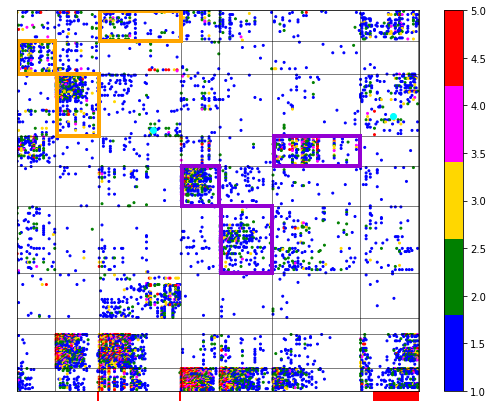

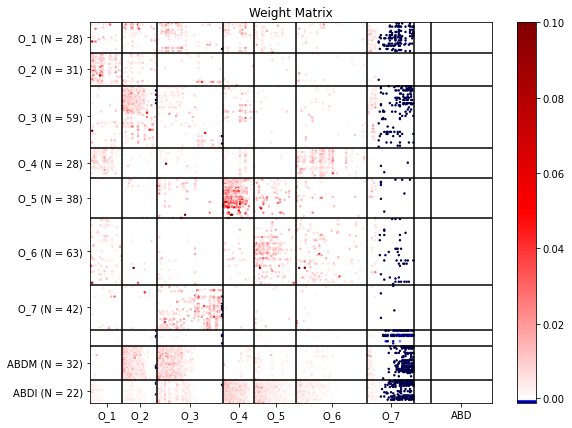

In [361]:
# plot weight matrices with and without normalization with specified block structure
pltbid = copy.deepcopy(sbmid7)
nmod = 7
pltbid[cellIDs == 'vSPNs'] = 100
pltbid[cellIDs == 'ABD_m'] = 101
pltbid[cellIDs == 'ABD_i'] = 102
#pltbid[pltbid == 1] = 99
#pltbid[pltbid == 5] = 1
#pltbid[pltbid == 4] = 5
#pltbid[pltbid == 6] = 4
#pltbid[pltbid == 2] = 6
#pltbid[pltbid == 3] = 2
#pltbid[pltbid == 99] = 3
#pltbid[pltbid == 5] = 4
#pltbid[pltbid == 8] = 5
#pltbid[pltbid == 99] = 8
#pltbid[pltbid == 3] = 5
#pltbid[pltbid == 4] = 3
#pltbid[pltbid == 2] = 4
#pltbid[pltbid == 99] = 2
#pltbid[pltbid == 6] = 99
#pltbid[pltbid == 7] = 6
#pltbid[pltbid == 99] = 7
N_axial = np.sum(pltbid == 0)
N_om = np.zeros(12,dtype=np.int32)
N_om[0] = np.sum(pltbid == 1)
N_om[1] = np.sum(pltbid == 2)
N_om[2] = np.sum(pltbid == 3)
N_om[3] = np.sum(pltbid == 4)
N_om[4] = np.sum(pltbid == 5)
N_om[5] = np.sum(pltbid == 6)
N_om[6] = np.sum(pltbid == 7)
N_om[7] = np.sum(pltbid == 8)
N_om[8] = np.sum(pltbid == 9)
N_om[9] = np.sum(pltbid == 10)
N_om[10] = np.sum(pltbid == 11)
N_om[11] = np.sum(pltbid == 12)
N_vspn = np.sum(pltbid == 100)
N_abdm = np.sum(pltbid == 101)
N_abdi = np.sum(pltbid == 102)
N_abd = N_abdm + N_abdi
blockOrder = pltbid.argsort()
A_sorted = []
W_sorted = []
x_a = []
y_a = []
x_a2 = []
y_a2 = []
x_w = []
y_w = []
do_ticks = []
dotl = []
#om1 = np.where(pltbid == 1)[0]
sbm_Wnorm[np.ix_(pltbid > 100,cellIDs == '_DOs_')] -= 1
for i in range(nmod):
    beg = int(N_axial + np.sum(N_om[0:i]))
    end = int(beg + N_om[i])
    newOrder = np.sum(-sbm_Wnorm[np.ix_(pltbid > 100,blockOrder[beg:end])],axis=0).argsort()
    blockOrder[beg:end] = blockOrder[beg:end][newOrder]
sbm_Wnorm[np.ix_(pltbid > 100,cellIDs == '_DOs_')] += 1
for j in range(N):
    if lb_cdf.loc['vest'][blockOrder[j]]:
    #if blockOrder[j] > N_axial and flag[blockOrder[j]]:
        do_ticks.append(j)
        dotl.append('')
W = copy.deepcopy(sbm_Wnorm)
for i in range(1,nmod+1):
    for j in range(1,nmod+1):
        W[np.ix_(pltbid==i,pltbid==j)] = np.mean(W[np.ix_(pltbid==i,pltbid==j)])
    W[np.ix_(pltbid==100,pltbid==i)] = np.mean(W[np.ix_(pltbid==100,pltbid==i)])
    W[np.ix_(pltbid==101,pltbid==i)] = np.mean(W[np.ix_(pltbid==101,pltbid==i)])
    W[np.ix_(pltbid==102,pltbid==i)] = np.mean(W[np.ix_(pltbid==102,pltbid==i)])
A = copy.deepcopy(connMat)
for i in range(1,nmod+1):
    for j in range(1,nmod+1):
        A[np.ix_(pltbid==i,pltbid==j)] = np.mean(A[np.ix_(pltbid==i,pltbid==j)])
    A[np.ix_(pltbid==100,pltbid==i)] = -1#np.mean(A[np.ix_(pltbid==100,pltbid==i)])
    A[np.ix_(pltbid==101,pltbid==i)] = np.mean(A[np.ix_(pltbid==101,pltbid==i)])
    A[np.ix_(pltbid==102,pltbid==i)] = np.mean(A[np.ix_(pltbid==102,pltbid==i)])
for i in range(N):
    for j in range(N):
        if connMat[blockOrder[i],blockOrder[j]] > 0:
            if pltbid[blockOrder[i]] != 100:
                y_a.append(N-1-i)
                x_a.append(j)
                A_sorted.append(connMat[blockOrder[i],blockOrder[j]])
                if blockOrder[i] == 539 or blockOrder[j] == 539:
                    y_a2.append(N-1-i)
                    x_a2.append(j)
                    #A_sorted.append(connMat[blockOrder[i],blockOrder[j]])
        #if abs(W[blockOrder[i],blockOrder[j]]) > 1e-15:
        if abs(sbm_Wnorm[blockOrder[i],blockOrder[j]]) > 1e-5:
            y_w.append(N-1-i)
            x_w.append(j)
            W_sorted.append(sbm_Wnorm[blockOrder[i],blockOrder[j]])
            #W_sorted.append(W[blockOrder[i],blockOrder[j]])
y_w = np.array(y_w,dtype=np.int32)
x_w = np.array(x_w,dtype=np.int32)
W_sorted = np.array(W_sorted)
#print(W_sorted[(pltbid[blockOrder[x_w]] == 1) & (pltbid[blockOrder[N - 1 - y_w]] == 1)])
#print(pltbid[(N-1) - y_w[:N_om[0]]])
#print(pltbid[x_w[:N_om[0]]])

#plt.figure(1,(2.6,2))
plt.figure(1,(9,7))
#cmap = ListedColormap(["navy", "blue", "lightseagreen","lawngreen","gold","darkorange","magenta","red"])
cmap = ListedColormap(["blue","green","gold","magenta","red"])
plt.scatter(x_a,y_a,c=A_sorted,cmap=cmap,vmax=5,s=4)
plt.plot(x_a2,y_a2,'o',color='cyan',markersize=6)
# TO PLOT BLOCK AVERAGES, COMMENT OUT LINE ABOVE AND UNCOMMENT LINE BELOW
#plt.imshow(A[np.ix_(blockOrder[::-1],blockOrder)],cmap=cmap,vmin=0.0,vmax=0.5)
plt.colorbar()
lw = 0.5
for i in range(1,nmod):
    plt.axvline(np.sum(pltbid < i+1)-0.5,color='black',linewidth=lw)
    plt.axhline(N-np.sum(pltbid < i+1)-0.5,color='black',linewidth=lw)
plt.axvline(np.sum(pltbid < 100)-0.5,color='black',linewidth=lw)
plt.axhline(N-np.sum(pltbid < 100)-0.5,color='black',linewidth=lw)
plt.axvline(np.sum(pltbid < 101)-0.5,color='black',linewidth=lw)
plt.axhline(N-np.sum(pltbid < 101)-0.5,color='black',linewidth=lw)
#plt.axvline(np.sum(pltbid < 102)-0.5,color='black',linewidth=lw)
plt.axhline(N-np.sum(pltbid < 102)-0.5,color='black',linewidth=lw)
cycle_color='orange'
plt.axvline(np.sum(pltbid < 1)+0.5,(N-np.sum(pltbid < 3)-0.5)/(N-N_axial),(N-np.sum(pltbid < 2)-0.5)/(N-N_axial),color=cycle_color,linewidth=lw*8)
plt.axvline(np.sum(pltbid < 2)-0.5,(N-np.sum(pltbid < 3)-0.5)/(N-N_axial),(N-np.sum(pltbid < 2)-0.5)/(N-N_axial),color=cycle_color,linewidth=lw*8)
plt.axhline(N-np.sum(pltbid < 2)-0.5,(np.sum(pltbid < 1)-N_axial+0.5)/(N-N_axial-N_abd-N_vspn),(np.sum(pltbid < 2)-N_axial-0.5)/(N-N_axial-N_abd-N_vspn),color=cycle_color,linewidth=lw*8)
plt.axhline(N-np.sum(pltbid < 3)-0.5,(np.sum(pltbid < 1)-N_axial+0.5)/(N-N_axial-N_abd-N_vspn),(np.sum(pltbid < 2)-N_axial-0.5)/(N-N_axial-N_abd-N_vspn),color=cycle_color,linewidth=lw*8)
plt.axvline(np.sum(pltbid < 2)+0.5,(N-np.sum(pltbid < 4)-0.5)/(N-N_axial),(N-np.sum(pltbid < 3)-0.5)/(N-N_axial),color=cycle_color,linewidth=lw*8)
plt.axvline(np.sum(pltbid < 3)-0.5,(N-np.sum(pltbid < 4)-0.5)/(N-N_axial),(N-np.sum(pltbid < 3)-0.5)/(N-N_axial),color=cycle_color,linewidth=lw*8)
plt.axhline(N-np.sum(pltbid < 3)-0.5,(np.sum(pltbid < 2)-N_axial+0.5)/(N-N_axial-N_abd-N_vspn),(np.sum(pltbid < 3)-N_axial-0.5)/(N-N_axial-N_abd-N_vspn),color=cycle_color,linewidth=lw*8)
plt.axhline(N-np.sum(pltbid < 4)-0.5,(np.sum(pltbid < 2)-N_axial+0.5)/(N-N_axial-N_abd-N_vspn),(np.sum(pltbid < 3)-N_axial-0.5)/(N-N_axial-N_abd-N_vspn),color=cycle_color,linewidth=lw*8)
plt.axvline(np.sum(pltbid < 3)+0.5,(N-np.sum(pltbid < 2)-0.5)/(N-N_axial),(N-np.sum(pltbid < 1)-0.5)/(N-N_axial),color=cycle_color,linewidth=lw*8)
plt.axvline(np.sum(pltbid < 4)-0.5,(N-np.sum(pltbid < 2)-0.5)/(N-N_axial),(N-np.sum(pltbid < 1)-0.5)/(N-N_axial),color=cycle_color,linewidth=lw*8)
plt.axhline(N-np.sum(pltbid < 1)-0.5,(np.sum(pltbid < 3)-N_axial+0.5)/(N-N_axial-N_abd-N_vspn),(np.sum(pltbid < 4)-N_axial-0.5)/(N-N_axial-N_abd-N_vspn),color=cycle_color,linewidth=lw*8)
plt.axhline(N-np.sum(pltbid < 2)-0.5,(np.sum(pltbid < 3)-N_axial+0.5)/(N-N_axial-N_abd-N_vspn),(np.sum(pltbid < 4)-N_axial-0.5)/(N-N_axial-N_abd-N_vspn),color=cycle_color,linewidth=lw*8)
cycle_color='darkviolet'
plt.axvline(np.sum(pltbid < 4)+0.5,(N-np.sum(pltbid < 6)-0.5)/(N-N_axial),(N-np.sum(pltbid < 5)-0.5)/(N-N_axial),color=cycle_color,linewidth=lw*8)
plt.axvline(np.sum(pltbid < 5)-0.5,(N-np.sum(pltbid < 6)-0.5)/(N-N_axial),(N-np.sum(pltbid < 5)-0.5)/(N-N_axial),color=cycle_color,linewidth=lw*8)
plt.axhline(N-np.sum(pltbid < 5)-0.5,(np.sum(pltbid < 4)-N_axial+0.5)/(N-N_axial-N_abd-N_vspn),(np.sum(pltbid < 5)-N_axial-0.5)/(N-N_axial-N_abd-N_vspn),color=cycle_color,linewidth=lw*8)
plt.axhline(N-np.sum(pltbid < 6)-0.5,(np.sum(pltbid < 4)-N_axial+0.5)/(N-N_axial-N_abd-N_vspn),(np.sum(pltbid < 5)-N_axial-0.5)/(N-N_axial-N_abd-N_vspn),color=cycle_color,linewidth=lw*8)
plt.axvline(np.sum(pltbid < 5)+0.5,(N-np.sum(pltbid < 7)-0.5)/(N-N_axial),(N-np.sum(pltbid < 6)-0.5)/(N-N_axial),color=cycle_color,linewidth=lw*8)
plt.axvline(np.sum(pltbid < 6)-0.5,(N-np.sum(pltbid < 7)-0.5)/(N-N_axial),(N-np.sum(pltbid < 6)-0.5)/(N-N_axial),color=cycle_color,linewidth=lw*8)
plt.axhline(N-np.sum(pltbid < 6)-0.5,(np.sum(pltbid < 5)-N_axial+0.5)/(N-N_axial-N_abd-N_vspn),(np.sum(pltbid < 6)-N_axial-0.5)/(N-N_axial-N_abd-N_vspn),color=cycle_color,linewidth=lw*8)
plt.axhline(N-np.sum(pltbid < 7)-0.5,(np.sum(pltbid < 5)-N_axial+0.5)/(N-N_axial-N_abd-N_vspn),(np.sum(pltbid < 6)-N_axial-0.5)/(N-N_axial-N_abd-N_vspn),color=cycle_color,linewidth=lw*8)
plt.axvline(np.sum(pltbid < 6)+0.5,(N-np.sum(pltbid < 5)-0.5)/(N-N_axial),(N-np.sum(pltbid < 4)-0.5)/(N-N_axial),color=cycle_color,linewidth=lw*8)
plt.axvline(np.sum(pltbid < 7)-0.5,(N-np.sum(pltbid < 5)-0.5)/(N-N_axial),(N-np.sum(pltbid < 4)-0.5)/(N-N_axial),color=cycle_color,linewidth=lw*8)
plt.axhline(N-np.sum(pltbid < 4)-0.5,(np.sum(pltbid < 6)-N_axial+0.5)/(N-N_axial-N_abd-N_vspn),(np.sum(pltbid < 7)-N_axial-0.5)/(N-N_axial-N_abd-N_vspn),color=cycle_color,linewidth=lw*8)
plt.axhline(N-np.sum(pltbid < 5)-0.5,(np.sum(pltbid < 6)-N_axial+0.5)/(N-N_axial-N_abd-N_vspn),(np.sum(pltbid < 7)-N_axial-0.5)/(N-N_axial-N_abd-N_vspn),color=cycle_color,linewidth=lw*8)

plt.xlim(N_axial,N-N_abd-N_vspn)
#plt.ylim(N_axial-1,N)
plt.ylim(0,N-N_axial)
xticks = []
yticks = []
xticklabels = []
yticklabels = []
for i in range(nmod):
    xticks.append(N_axial + np.sum(N_om[0:i]) + N_om[i]/2)
    yticks.append(N - (N_axial + np.sum(N_om[0:i]) + N_om[i]/2))
    xticklabels.append('O_{0:d}'.format(i+1,))
    yticklabels.append('O_{0:d} (N = {1:d})'.format(i+1,int(N_om[i])))
xticks.append(N_axial + np.sum(N_om) + N_vspn + N_abd/2)
xticklabels.append('ABD')
yticks.append(N - (N_axial + np.sum(N_om) + N_vspn + N_abdm/2))
yticklabels.append('ABDM (N = {0:d})'.format(N_abdm))
yticks.append(N - (N_axial + np.sum(N_om) + N_vspn + N_abdm + N_abdi/2))
yticklabels.append('ABDI (N = {0:d})'.format(N_abdi))
#plt.xticks(xticks,xticklabels,fontsize=5)
#plt.yticks(yticks,yticklabels,fontsize=5)
plt.xticks(do_ticks,dotl)
plt.yticks([],[])
ax = plt.gca()
ax.tick_params(colors='red',length=10,width=2)
#plt.savefig('plots/connectome_paper/adjacency_SBM_{0:d}blocks_raw_connectome.pdf'.format(nmod),dpi=500,transparent=True)

plt.figure(2,(9,7))
plt.scatter(x_w,y_w,c=W_sorted,cmap='seismic',norm=MidpointNormalize(midpoint=0,vmin=-0.001,vmax=0.1),s=2)
# TO PLOT BLOCK AVERAGES, COMMENT OUT LINE ABOVE AND UNCOMMENT LINE BELOW
#plt.imshow(W[np.ix_(blockOrder[::-1],blockOrder)],cmap='seismic',norm=MidpointNormalize(midpoint=0,vmin=-0.001))
plt.colorbar()
for i in range(1,nmod):
    plt.axvline(np.sum(pltbid < i+1)-0.5,color='black')
    plt.axhline(N-np.sum(pltbid < i+1)-0.5,color='black')
plt.axvline(np.sum(pltbid < 100)-0.5,color='black')
plt.axhline(N-np.sum(pltbid < 100)-0.5,color='black')
plt.axvline(np.sum(pltbid < 101)-0.5,color='black')
plt.axhline(N-np.sum(pltbid < 101)-0.5,color='black')
#plt.axvline(np.sum(pltbid < 102)-0.5,color='black')
plt.axhline(N-np.sum(pltbid < 102)-0.5,color='black')
plt.xlim(N_axial-1,N)
#plt.ylim(N_axial-1,N)
plt.ylim(0,N-N_axial)
xticks = []
yticks = []
xticklabels = []
yticklabels = []
for i in range(nmod):
    xticks.append(N_axial + np.sum(N_om[0:i]) + N_om[i]/2)
    yticks.append(N - (N_axial + np.sum(N_om[0:i]) + N_om[i]/2))
    xticklabels.append('O_{0:d}'.format(i+1,))
    yticklabels.append('O_{0:d} (N = {1:d})'.format(i+1,int(N_om[i])))
xticks.append(N_axial + np.sum(N_om) + N_vspn + N_abd/2)
xticklabels.append('ABD')
yticks.append(N - (N_axial + np.sum(N_om) + N_vspn + N_abdm/2))
yticklabels.append('ABDM (N = {0:d})'.format(N_abdm))
yticks.append(N - (N_axial + np.sum(N_om) + N_vspn + N_abdm + N_abdi/2))
yticklabels.append('ABDI (N = {0:d})'.format(N_abdi))
plt.xticks(xticks,xticklabels)
plt.yticks(yticks,yticklabels)
plt.title('Weight Matrix')
#plt.savefig('weights_SBM_{0:d}blocks_averaged.pdf'.format(nmod),dpi=500,transparent=True)

In [15]:
# plot eigenspectrum for specified weight matrix
#W = copy.deepcopy(sbm_A) # currently using unnormalized adjacency with all excitatory connections
W = copy.deepcopy(connMat)
W[:,lb_cdf.loc['abdm']] = 0
W[:,lb_cdf.loc['abdi']] = 0
W[:,lb_cdf.loc['vspns']] = 0
W[:,lb_cdf.loc['axl']] = 0
W[lb_cdf.loc['axl'],:] = 0
#W[:,flag] = 0
#W[flag,:] = 0
# UNCOMMENT LINE BELOW TO FLIP SIGN OF DO POPULATION
#W[:,lb_cdf.loc['vest']] = -W[:,lb_cdf.loc['vest']]
#W[:,lb_cdf.loc['vest']] = 0
#W[lb_cdf.loc['vest'],:] = 0
y,v = sorted_eigs(W)
eig_sf = 1.0 / abs(y[0])
mp_mask = (sbmid7 == 1) | (sbmid7 == 2) | (sbmid7 == 3) | (sbmid7 == 7)
ip_mask = (sbmid7 == 4) | (sbmid7 == 5) | (sbmid7 == 6)
# UNCOMMENT LINES BELOW TO SHUFFLE
test_bid = copy.deepcopy(sbmid)
# WHOLE ModO
#test_bid[test_bid > 0] = 1
# MOTOR AND INTERNUCLEAR GROUPS
#test_bid[mp_mask] = 1
#test_bid[ip_mask] = 2
# INTERNUCLEAR CYCLE
test_bid[mp_mask] = 0
test_bid[ip_mask] = 1
W_shuffled = shuffle_synapses_iodp_exact(copy.deepcopy(W),copy.deepcopy(totalInputs),test_bid-1,returnAdjacency=True)
while np.sum(W) < 0:
    W_shuffled = shuffle_synapses_iodp_exact(copy.deepcopy(W),copy.deepcopy(totalInputs),test_bid-1,returnAdjacency=True)
#W = W_shuffled
# UNCOMMENT LINES BELOW TO REMOVE INTERCYCLE CONNECTIONS
#W[np.ix_(mp_mask,ip_mask)] = 0
#W[np.ix_(ip_mask,mp_mask)] = 0
W = copy.deepcopy(lb_Wnorm)
y,v1 = sorted_eigs(W)
W[:,flag] = 0
W[flag,:] = 0
y,v = sorted_eigs(W)
eig_sf = 1.0 / abs(y[0])
#y,v = sorted_eigs(W)
y = y * eig_sf

Text(0, 0.5, 'Im($\\lambda$)')

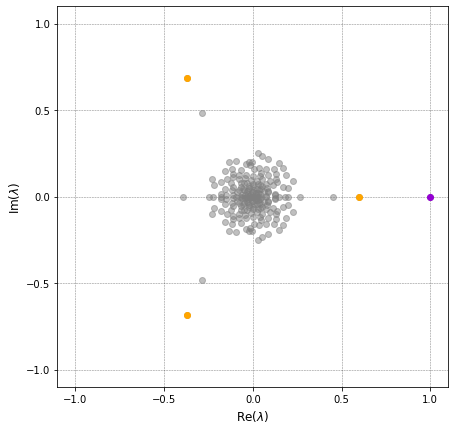

In [16]:
plt.figure(1,(7,7))
plt.axvline(-1.0,color='black',linestyle='--',linewidth=0.5,alpha=0.5)
plt.axvline(-0.5,color='black',linestyle='--',linewidth=0.5,alpha=0.5)
plt.axvline(0.0,color='black',linestyle='--',linewidth=0.5,alpha=0.5)
plt.axvline(0.5,color='black',linestyle='--',linewidth=0.5,alpha=0.5)
plt.axvline(1.0,color='black',linestyle='--',linewidth=0.5,alpha=0.5)
plt.axhline(-1.0,color='black',linestyle='--',linewidth=0.5,alpha=0.5)
plt.axhline(-0.5,color='black',linestyle='--',linewidth=0.5,alpha=0.5)
plt.axhline(0.0,color='black',linestyle='--',linewidth=0.5,alpha=0.5)
plt.axhline(0.5,color='black',linestyle='--',linewidth=0.5,alpha=0.5)
plt.axhline(1.0,color='black',linestyle='--',linewidth=0.5,alpha=0.5)
y_1 = np.array([y[0]],dtype=np.complex128)
y_2 = np.array([y[1],y[-2],y[-3]],dtype=np.complex128)
y_3 = y[2:3]
plt.plot(np.real(y),np.imag(y),'o',color='grey',alpha=0.5,label='unperturbed network')
plt.plot(np.real(y_1),np.imag(y_1),'o',color='darkviolet')
plt.plot(np.real(y_2),np.imag(y_2),'o',color='orange')
#plt.plot(np.real(y_3),np.imag(y_3),'o',color='green')
plt.xticks([-1.0,-0.5,0.0,0.5,1.0])
plt.yticks([-1.0,-0.5,0.0,0.5,1.0])
plt.xlabel('Re($\\lambda$)',fontsize=12)
plt.ylabel('Im($\\lambda$)',fontsize=12)
#plt.savefig('plots/eigenvalues_raw_connectome_excitatory_DO_internuclear_shuffled_uncoupled.pdf',dpi=500,transparent=True)

Text(0, 0.5, 'eigenvector entry')

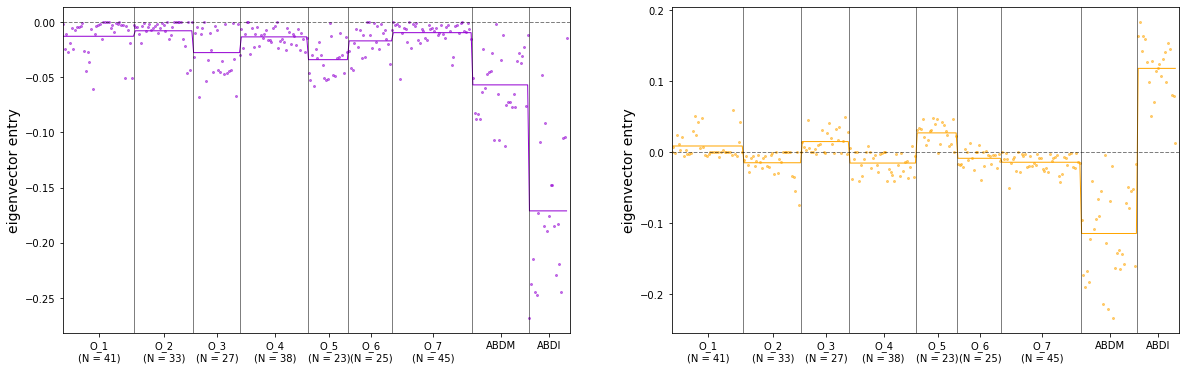

In [51]:
pltbid = copy.deepcopy(sbmid7)
nmod = 7
pltbid[cellIDs == 'vSPNs'] = -100
pltbid[cellIDs == 'ABD_m'] = 101
pltbid[cellIDs == 'ABD_i'] = 102
#pltbid[pltbid == 1] = 99
#pltbid[pltbid == 2] = 1
#pltbid[pltbid == 99] = 2
N_axial = np.sum(pltbid <= 0)
N_om = np.zeros(12)
N_om[0] = np.sum(pltbid == 1)
N_om[1] = np.sum(pltbid == 2)
N_om[2] = np.sum(pltbid == 3)
N_om[3] = np.sum(pltbid == 4)
N_om[4] = np.sum(pltbid == 5)
N_om[5] = np.sum(pltbid == 6)
N_om[6] = np.sum(pltbid == 7)
N_om[7] = np.sum(pltbid == 8)
N_om[8] = np.sum(pltbid == 9)
N_om[9] = np.sum(pltbid == 10)
N_om[10] = np.sum(pltbid == 11)
N_om[11] = np.sum(pltbid == 12)
N_vspn = 0#np.sum(pltbid == 100)
N_abdm = np.sum(pltbid == 101)
N_abdi = np.sum(pltbid == 102)
blockOrder = pltbid.argsort()
vL = np.linalg.pinv(v)
v = np.real(v)
v2 = copy.deepcopy(v)
for i in range(1,8):
    v2[pltbid==i,0] = np.mean(v[pltbid==i,0])
    v2[pltbid==i,1] = np.mean(v[pltbid==i,1])
    v2[pltbid==i,2] = np.mean(v[pltbid==i,2])
    v2[pltbid==i,-2] = np.mean(v[pltbid==i,-2])
    v2[pltbid==i,-6] = np.mean(v[pltbid==i,-6])
for i in range(101,103):
    v2[pltbid==i,0] = np.mean(v[pltbid==i,0])
    v2[pltbid==i,1] = np.mean(v[pltbid==i,1])
    v2[pltbid==i,2] = np.mean(v[pltbid==i,2])
    v2[pltbid==i,-2] = np.mean(v[pltbid==i,-2])
    v2[pltbid==i,-6] = np.mean(v[pltbid==i,-6])
    
xticks = [N_axial/2]
xticklabels = ['modA']
for i in range(nmod):
    xticks.append(N_axial + np.sum(N_om[0:i]) + N_om[i]/2)
    xticklabels.append('O_{0:d}\n(N = {1:d})'.format(i+1,int(N_om[i])))
xticks.append(N_axial + np.sum(N_om) + N_vspn + N_abdm/2)
xticklabels.append('ABDM')
xticks.append(N_axial + np.sum(N_om) + N_vspn + N_abdm + N_abdi/2)
xticklabels.append('ABDI')

plt.figure(1,(20,6))
plt.subplot(121)
plt.plot(v[blockOrder,0],'o',markersize=2,label='leading mode',color='darkviolet',alpha=0.5)
plt.plot(v2[blockOrder,0],'-',linewidth=1,label='leading mode block avg',color='darkviolet')
plt.xlim(-1,610)
plt.axvline(np.sum(pltbid == 0)-0.5,color='black')
for i in range(1,nmod):
    plt.axvline(np.sum(pltbid < i+1)-0.5,color='black',linewidth=0.5)
#plt.axvline(np.sum(pltbid < 100)-0.5,color='black',linewidth=0.5)
plt.axvline(np.sum(pltbid < 101)-0.5,color='black',linewidth=0.5)
plt.axvline(np.sum(pltbid < 102)-0.5,color='black',linewidth=0.5)
plt.axhline(0,color='black',linewidth=1,linestyle='--',alpha=0.5)
plt.xticks(xticks,xticklabels)
plt.xlim(N_axial,N+1)
#plt.legend(fontsize=12)
plt.ylabel('eigenvector entry',fontsize=14)

plt.subplot(122)
plt.plot(-v[blockOrder,1],'o',markersize=2,label='2nd mode',color='orange',alpha=0.5)
plt.plot(-v2[blockOrder,1],'-',linewidth=1,label='2nd mode block avg',color='orange')
plt.xlim(-1,610)
plt.axvline(np.sum(pltbid == 0)-0.5,color='black')
for i in range(1,nmod):
    plt.axvline(np.sum(pltbid < i+1)-0.5,color='black',linewidth=0.5)
#plt.axvline(np.sum(pltbid < 100)-0.5,color='black',linewidth=0.5)
plt.axvline(np.sum(pltbid < 101)-0.5,color='black',linewidth=0.5)
plt.axvline(np.sum(pltbid < 102)-0.5,color='black',linewidth=0.5)
plt.axhline(0,color='black',linewidth=1,linestyle='--',alpha=0.5)
plt.xticks(xticks,xticklabels)
plt.xlim(N_axial,N+1)
#plt.legend(fontsize=12)
plt.ylabel('eigenvector entry',fontsize=14)

#plt.savefig('plots/eigenvectors_raw_connectome_excitatory_DO.pdf',dpi=500,transparent=True)

<h1> Impact of Shuffles that Preserve Block Structure </h1>

In [159]:
A = copy.deepcopy(connMat)
A[:,lb_cdf.loc['abdm']] = 0
A[:,lb_cdf.loc['abdi']] = 0
A[:,lb_cdf.loc['vspns']] = 0
A[:,lb_cdf.loc['axl']] = 0
A[lb_cdf.loc['axl'],:] = 0
N_shuffles = 100
shuffled_slopes = np.zeros((N,N_shuffles))
shuffled_eigs = np.zeros((N,N_shuffles),dtype=np.complex128)
shuffled_coefs_cn = np.zeros((N,2,N_shuffles))
shuffled_cv_cn = np.zeros((10,N_shuffles))
test_bid = copy.deepcopy(lbid) # put block ids in here, currently using 7-block clustering of modO
y,v = sorted_eigs(lb_Wnorm)
eig_sf = 1.0 / abs(y[0])
for i in range(N_shuffles):
    W = shuffle_synapses_iodp_exact(copy.deepcopy(A),copy.deepcopy(totalInputs),test_bid-1)
    while np.sum(W) < 0:
        W = shuffle_synapses_iodp_exact(copy.deepcopy(A),copy.deepcopy(totalInputs),test_bid-1)
    W = final_adjustments(W,lb_cdf)
    y,v2 = sorted_eigs(W)
    # slopes from leading eigenvector
    #slopes = np.real(v[:,0])
    # slopes from simulation
    my_v_in2 = 0.1*abs(np.random.randn(N)) + np.real(np.sum(v2[:,0:1],axis=1)) + np.imag(np.sum(v2[:,0:1],axis=1))
    my_v_in2 += 1*np.real(np.sum(v2[:,1:3],axis=1)) + np.imag(np.sum(v2[:,1:3],axis=1))
    slopes = simulate_ks(W,np.max(np.real(y)),ynew=0.9,tau=1,v_in=mu_v_in2)
    sf = 2.574 / np.mean(slopes[lb_cdf.loc['integ']])
    shuffled_slopes[:,i] = sf*slopes#get_scaled_slopes(W,lb_cdf)#,sf=lb_sf)
    shuffled_eigs[:,i] = y[:] / abs(y[0])
    for j in range(3):
        if np.dot(np.real(v[:,j]),np.real(v2[:,j])) < 0:
            v2[:,j] = -v2[:,j]
    lb_rates = simulate(W,ynew=0.9,tau=1.0,customInput=True,v_in=my_v_in2)
    coefs_cn = fit_2exp_fixed_tau(lb_rates,10,4)
    sf1_cn = 1.0/np.std(coefs_cn[cell_filter,0])
    shuffled_coefs_cn[:,:,i] = coefs_cn*sf1_cn
    u_cn,s_cn,v_cn = np.linalg.svd(lb_rates[:,cell_filter])
    cv_cn = s_cn[:10]**2/np.sum(s_cn**2)
    for j in range(1,10):
        cv_cn[j] += cv_cn[j-1]
    shuffled_cv_cn[:,i] = cv_cn[:]

68


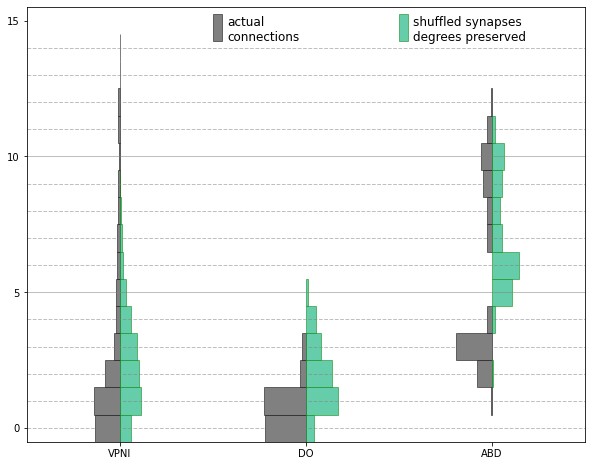

In [26]:
plt.figure(1,(10,8))
#compare_khist([np.reshape(lb_slopes,(N,1)),shuffled_slopes[:,:]],[lb_cdf,lb_cdf],['actual\nconnections','shuffled synapses\ndegrees preserved'])
compare_khist([lb_slopes_sim,shuffled_slopes[:,:]],[lb_cdf,lb_cdf],['actual\nconnections','shuffled synapses\ndegrees preserved'])
#plt.savefig('plots/kvalues_SBM_shuffled_synapses_alldeg_preserved_exact_1block.pdf',dpi=500,transparent=True)

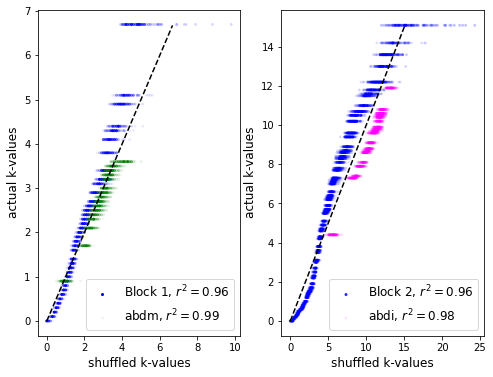

In [74]:
plt.figure(1,(8,6))
plot_ks_by_block(lb_slopes_sim,shuffled_slopes[:,:],lb_cdf,test_bid,[1],[2],arrangement='horizontal',ms=4)
#plt.savefig('plots/kvalues_scatter_SBM_shuffled_synapses_alldeg_preserved_exact_2block.pdf',dpi=500,transparent=True)

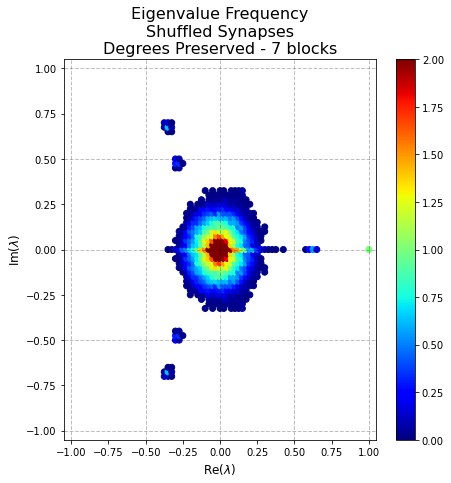

In [182]:
plt.figure(1,(7,7))
plot_eig_frequency(shuffled_eigs,'Eigenvalue Frequency\nShuffled Synapses\nDegrees Preserved - 7 blocks',nbins=83)
#plt.savefig('plots/eigenvalues_SBM_shuffled_synapses_alldeg_preserved_exact_7block.pdf',dpi=500,transparent=True)

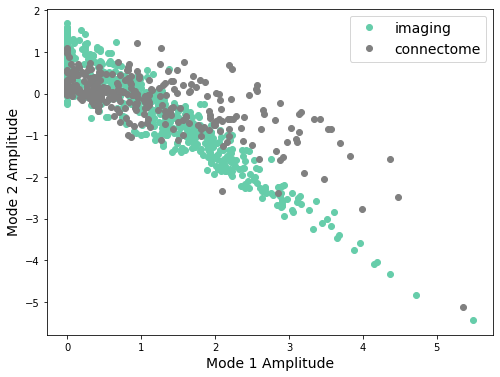

In [163]:
coefs_im = fit_2exp_fixed_tau(stas_adj,10,4)
sf1_im = 1.0/np.std(coefs_im[:,0])
coefs_im = coefs_im*sf1_im

plt.figure(1,(8,6))
plt.plot(coefs_im[:,0],coefs_im[:,1],'o',label='imaging',color='mediumaquamarine')
plt.plot(shuffled_coefs_cn[cell_filter,0,2],shuffled_coefs_cn[cell_filter,1,2],'o',label='connectome',color='gray')
plt.xlabel('Mode 1 Amplitude',fontsize=14)
plt.ylabel('Mode 2 Amplitude',fontsize=14)
plt.legend(fontsize=14)
#plt.savefig('plots/double_exponential_fit_shuffled_synapses_alldeg_preserved_exact_7block.pdf',dpi=300,transparent=True)

(0.7, 1.01)

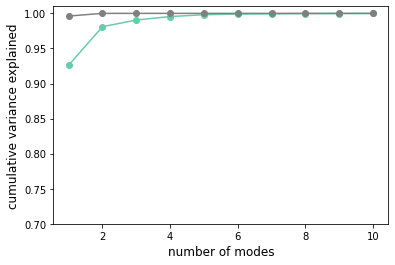

In [161]:
plt.plot(np.linspace(1,10,10),cv_im,'o-',color='mediumaquamarine',label='imaging')
plt.errorbar(np.linspace(1,10,10),np.mean(shuffled_cv_cn,axis=1),yerr=np.std(shuffled_cv_cn,axis=1),fmt='o-',color='gray',label='connectome')
plt.xlabel('number of modes',fontsize=12)
plt.ylabel('cumulative variance explained',fontsize=12)
plt.ylim(0.7,1.01)
#plt.savefig('plots/cumulative_variance_explained_shuffled_synapses_alldeg_preserved_exact_7block.pdf',dpi=300,transparent=True)

[1.        +0.j 0.63730322+0.j 0.20934991+0.j]


Text(0, 0.5, 'Im($\\lambda$)')

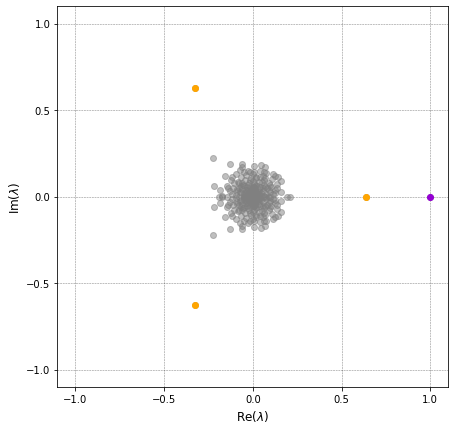

In [110]:
A = copy.deepcopy(connMat)
A[:,lb_cdf.loc['abdm']] = 0
A[:,lb_cdf.loc['abdi']] = 0
A[:,lb_cdf.loc['vspns']] = 0
A[:,lb_cdf.loc['axl']] = 0
A[lb_cdf.loc['axl'],:] = 0
# UNCOMMENT LINE BELOW TO FLIP SIGN OF DO POPULATION
#A[:,lb_cdf.loc['vest']] = -A[:,lb_cdf.loc['vest']]
#A[:,lb_cdf.loc['vest']] = 0
#A[lb_cdf.loc['vest'],:] = 0
y,v = sorted_eigs(A)
eig_sf = 1.0 / abs(y[0])
mp_mask = (sbmid7 == 1) | (sbmid7 == 2) | (sbmid7 == 3) | (sbmid7 == 7)
ip_mask = (sbmid7 == 4) | (sbmid7 == 5) | (sbmid7 == 6)
#mp_mask = (lbid2 == 1)
#ip_mask = (lbid2 == 2)
# UNCOMMENT LINES BELOW TO REMOVE INTERCYCLE CONNECTIONS
#A[np.ix_(mp_mask,ip_mask)] = 0
#A[np.ix_(ip_mask,mp_mask)] = 0

test_bid = copy.deepcopy(sbmid5) # put block ids in here, currently using 7-block clustering of modO
#test_bid[test_bid == 5] = 4
#test_bid[test_bid == 6] = 4
#test_bid[test_bid == 4] = 2
#test_bid[test_bid == 5] = 3
#test_bid[test_bid == 6] = 4
test_bid[test_bid == 7] = 5
W = shuffle_synapses_iodp_exact(A,copy.deepcopy(totalInputs),test_bid-1)
while np.sum(W) < 0:
    W = shuffle_synapses_iodp_exact(A,copy.deepcopy(totalInputs),test_bid-1)

y,v = sorted_eigs(W)
y = y / abs(y[0])
print(y[0:3])
plt.figure(1,(7,7))
plt.axvline(-1.0,color='black',linestyle='--',linewidth=0.5,alpha=0.5)
plt.axvline(-0.5,color='black',linestyle='--',linewidth=0.5,alpha=0.5)
plt.axvline(0.0,color='black',linestyle='--',linewidth=0.5,alpha=0.5)
plt.axvline(0.5,color='black',linestyle='--',linewidth=0.5,alpha=0.5)
plt.axvline(1.0,color='black',linestyle='--',linewidth=0.5,alpha=0.5)
plt.axhline(-1.0,color='black',linestyle='--',linewidth=0.5,alpha=0.5)
plt.axhline(-0.5,color='black',linestyle='--',linewidth=0.5,alpha=0.5)
plt.axhline(0.0,color='black',linestyle='--',linewidth=0.5,alpha=0.5)
plt.axhline(0.5,color='black',linestyle='--',linewidth=0.5,alpha=0.5)
plt.axhline(1.0,color='black',linestyle='--',linewidth=0.5,alpha=0.5)
y_1 = np.array([y[0]],dtype=np.complex128)
y_2 = np.array([y[1],y[-1],y[-2]],dtype=np.complex128)
y_3 = y[2:3]
plt.plot(np.real(y),np.imag(y),'o',color='grey',alpha=0.5,label='unperturbed network')
plt.plot(np.real(y_1),np.imag(y_1),'o',color='darkviolet')
plt.plot(np.real(y_2),np.imag(y_2),'o',color='orange')
#plt.plot(np.real(y_3),np.imag(y_3),'o',color='green')
plt.xticks([-1.0,-0.5,0.0,0.5,1.0])
plt.yticks([-1.0,-0.5,0.0,0.5,1.0])
plt.xlabel('Re($\\lambda$)',fontsize=12)
plt.ylabel('Im($\\lambda$)',fontsize=12)
#plt.savefig('plots/eigenvalues_typical_shuffle_alldeg_preserved_exact_SBM_7block_internuclear_cycle_combined_raw_no_DO_interblock_connections_removed.pdf',dpi=500,transparent=True)

<h1> Potential Synapses </h1>

In [30]:
cellFile = 'data/AllCells.mat'
cells = scipy.io.loadmat(cellFile)
cell_locs = np.zeros(N,dtype=np.int32)
for i in range(N):
    cell_locs[i] = np.where(cells['AllCells'][:,0] == idpos[i])[0]

connMatFile = 'data/potentialSynapses_2.mat'
connMatPot2 = scipy.io.loadmat(connMatFile)
connMatDict = list(connMatPot2)
connMatPot2 = np.float32(connMatPot2[connMatDict[-1]])
totalInputsPot2 = np.sum(connMatPot2[cell_locs,:],axis=1)
connMatPot2 = connMatPot2[np.ix_(cell_locs,cell_locs)]

connMatFile = 'data/potentialSynapses_5.mat'
connMatPot5 = scipy.io.loadmat(connMatFile)
connMatDict = list(connMatPot5)
connMatPot5 = np.float32(connMatPot5[connMatDict[-1]])
totalInputsPot5 = np.sum(connMatPot5[cell_locs,:],axis=1)
connMatPot5 = connMatPot5[np.ix_(cell_locs,cell_locs)]

connMatFile = 'data/potentialSynapses_10.mat'
connMatPot10 = scipy.io.loadmat(connMatFile)
connMatDict = list(connMatPot10)
connMatPot10 = np.float32(connMatPot10[connMatDict[-1]])
totalInputsPot10 = np.sum(connMatPot10[cell_locs,:],axis=1)
connMatPot10 = connMatPot10[np.ix_(cell_locs,cell_locs)]

f = open('data/potentialSynapses_louvainBlockAssignments.data','rb')
blockDict = pickle.load(f)
f.close()
lbid_pot2 = blockDict['Potential Synapses 2um']
lbid_pot5 = blockDict['Potential Synapses 5um']
lbid_pot10 = blockDict['Potential Synapses 10um']

cellLocations =  np.array([(lbid_pot2 == 1) & (cellIDs != '_DOs_'),(cellIDs == 'Ibn_m'),(cellIDs == 'Ibn_i'),(cellIDs == '_MOs_'),(cellIDs == '_Axlm'), (lbid_pot2 == 0), (cellIDs == '_DOs_'),(cellIDs == 'ABD_m'),(cellIDs == 'ABD_i'), (cellIDs == 'vSPNs')])
lb_cdf_pot2 = pandas.DataFrame(cellLocations,cellNames)

cellLocations =  np.array([(lbid_pot5 == 1) & (cellIDs != '_DOs_'),(cellIDs == 'Ibn_m'),(cellIDs == 'Ibn_i'),(cellIDs == '_MOs_'),(cellIDs == '_Axlm'), (lbid_pot5 == 0), (cellIDs == '_DOs_'),(cellIDs == 'ABD_m'),(cellIDs == 'ABD_i'), (cellIDs == 'vSPNs')])
lb_cdf_pot5 = pandas.DataFrame(cellLocations,cellNames)

cellLocations =  np.array([(lbid_pot10 == 1) & (cellIDs != '_DOs_'),(cellIDs == 'Ibn_m'),(cellIDs == 'Ibn_i'),(cellIDs == '_MOs_'),(cellIDs == '_Axlm'), (lbid_pot10 == 0), (cellIDs == '_DOs_'),(cellIDs == 'ABD_m'),(cellIDs == 'ABD_i'), (cellIDs == 'vSPNs')])
lb_cdf_pot10 = pandas.DataFrame(cellLocations,cellNames)

lb_Wnorm_pot2 = np.zeros(connMat.shape)
lb_Wnorm_pot5 = np.zeros(connMat.shape)
lb_Wnorm_pot10 = np.zeros(connMat.shape)
for i in np.arange(connMat.shape[0]):
    if totalInputs[i]>0:
        lb_Wnorm_pot2[i,:] = connMatPot2[i,:] / totalInputsPot2[i,None]
        lb_Wnorm_pot5[i,:] = connMatPot5[i,:] / totalInputsPot5[i,None]
        lb_Wnorm_pot10[i,:] = connMatPot10[i,:] / totalInputsPot10[i,None]
lb_Wnorm_pot2 = final_adjustments(lb_Wnorm_pot2,lb_cdf_pot2)
lb_Wnorm_pot5 = final_adjustments(lb_Wnorm_pot5,lb_cdf_pot5)
lb_Wnorm_pot10 = final_adjustments(lb_Wnorm_pot10,lb_cdf_pot10)
lb_slopes_pot2 = get_scaled_slopes(lb_Wnorm_pot2,lb_cdf_pot2)
lb_slopes_pot5 = get_scaled_slopes(lb_Wnorm_pot5,lb_cdf_pot5)
lb_slopes_pot10 = get_scaled_slopes(lb_Wnorm_pot10,lb_cdf_pot10)

In [31]:
y,v = sorted_eigs(lb_Wnorm_pot2)
lb_slopes_sim_pot2 = np.zeros((N,100))
for i in range(100):
    slopes = simulate_ks(lb_Wnorm_pot2,np.real(y[0]),ynew=0.9,tau=1)
    sf = 2.574 / np.mean(slopes[lb_cdf_pot2.loc['integ']])
    lb_slopes_sim_pot2[:,i] = slopes*sf
    
y,v = sorted_eigs(lb_Wnorm_pot5)
lb_slopes_sim_pot5 = np.zeros((N,100))
for i in range(100):
    slopes = simulate_ks(lb_Wnorm_pot5,np.real(y[0]),ynew=0.9,tau=1)
    sf = 2.574 / np.mean(slopes[lb_cdf_pot5.loc['integ']])
    lb_slopes_sim_pot5[:,i] = slopes*sf
    
y,v = sorted_eigs(lb_Wnorm_pot10)
lb_slopes_sim_pot10 = np.zeros((N,100))
for i in range(100):
    slopes = simulate_ks(lb_Wnorm_pot10,np.real(y[0]),ynew=0.9,tau=1)
    sf = 2.574 / np.mean(slopes[lb_cdf_pot10.loc['integ']])
    lb_slopes_sim_pot10[:,i] = slopes*sf

68
2


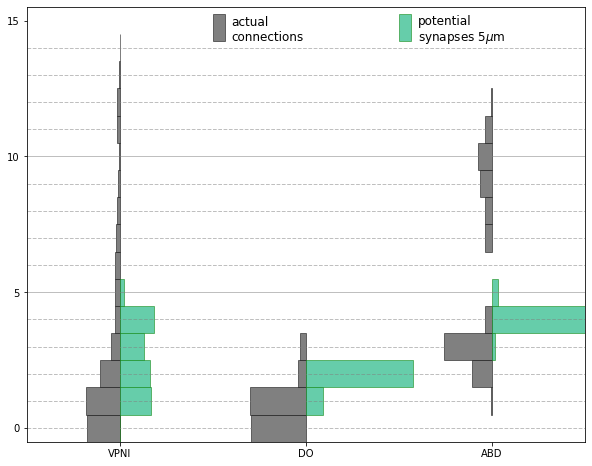

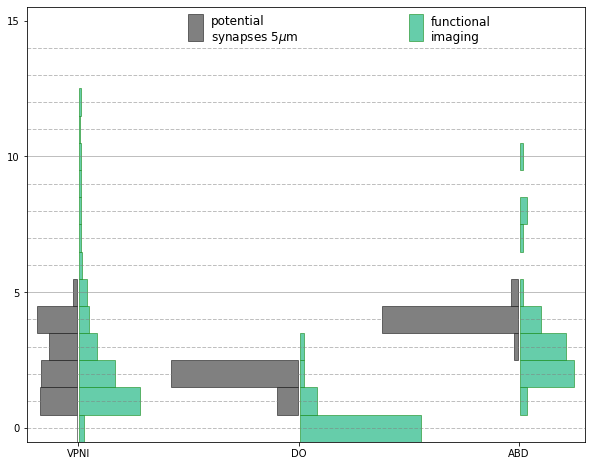

In [32]:
plt.figure(1,(10,8))
#compare_khist([np.reshape(lb_slopes,(N,1)),np.reshape(lb_slopes_pot2,(N,1))],[lb_cdf,lb_cdf_pot2],['actual\nconnections','potential\nsynapses 2$\mu$m'])
compare_khist([lb_slopes_sim,lb_slopes_sim_pot5],[lb_cdf,lb_cdf_pot5],['actual\nconnections','potential\nsynapses 5$\mu$m'],spacing=0.75)
#plt.savefig('plots/kvalues_compare_actual_potential_synapses_5um.pdf',dpi=500,transparent=True)

plt.figure(2,(10,8))
compare_khist([lb_slopes_sim_pot5,np.reshape(fi_slopes,(Nexp,1))],[lb_cdf_pot5,fi_cdf],['potential\nsynapses 5$\mu$m','functional\nimaging'],spacing=0.75,gap=0.007)
plt.xlim(0.4,4.2)
#plt.savefig('plots/kvalues_compare_imaging_potential_synapses_5um.pdf',dpi=500,transparent=True)

<h1> Comparison of 7 Blocks to 2 Blocks </h1>

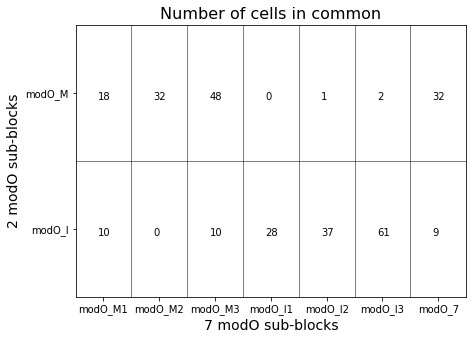

In [145]:
plt.figure(1,(7,5))
plt.axhline(1,color='black',linewidth=0.5)
plt.axvline(1,color='black',linewidth=0.5)
plt.axvline(2,color='black',linewidth=0.5)
plt.axvline(3,color='black',linewidth=0.5)
plt.axvline(4,color='black',linewidth=0.5)
plt.axvline(5,color='black',linewidth=0.5)
plt.axvline(6,color='black',linewidth=0.5)
plt.xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5],['modO_M1','modO_M2','modO_M3','modO_I1','modO_I2','modO_I3','modO_7'])
plt.yticks([0.5,1.5],['modO_I','modO_M'])
plt.xlim(0,7)
plt.ylim(0,2)
plt.text(0.4,0.45,'{0:d}'.format(np.sum((sbmid7 == 1) & (lbid2 == 1))))
plt.text(1.4,0.45,'{0:d}'.format(np.sum((sbmid7 == 2) & (lbid2 == 1))))
plt.text(2.4,0.45,'{0:d}'.format(np.sum((sbmid7 == 3) & (lbid2 == 1))))
plt.text(3.4,0.45,'{0:d}'.format(np.sum((sbmid7 == 4) & (lbid2 == 1))))
plt.text(4.4,0.45,'{0:d}'.format(np.sum((sbmid7 == 5) & (lbid2 == 1))))
plt.text(5.4,0.45,'{0:d}'.format(np.sum((sbmid7 == 6) & (lbid2 == 1))))
plt.text(6.4,0.45,'{0:d}'.format(np.sum((sbmid7 == 7) & (lbid2 == 1))))
plt.text(0.4,1.45,'{0:d}'.format(np.sum((sbmid7 == 1) & (lbid2 == 2))))
plt.text(1.4,1.45,'{0:d}'.format(np.sum((sbmid7 == 2) & (lbid2 == 2))))
plt.text(2.4,1.45,'{0:d}'.format(np.sum((sbmid7 == 3) & (lbid2 == 2))))
plt.text(3.4,1.45,'{0:d}'.format(np.sum((sbmid7 == 4) & (lbid2 == 2))))
plt.text(4.4,1.45,'{0:d}'.format(np.sum((sbmid7 == 5) & (lbid2 == 2))))
plt.text(5.4,1.45,'{0:d}'.format(np.sum((sbmid7 == 6) & (lbid2 == 2))))
plt.text(6.4,1.45,'{0:d}'.format(np.sum((sbmid7 == 7) & (lbid2 == 2))))
plt.title('Number of cells in common',fontsize=16)
plt.xlabel('7 modO sub-blocks',fontsize=14)
plt.ylabel('2 modO sub-blocks',fontsize=14)
plt.savefig('plots/table_of_common_cells_2block_7block.pdf',dpi=500,transparent=True)

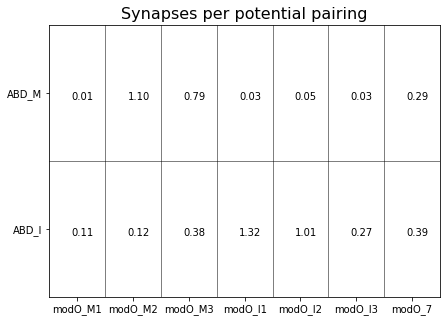

In [147]:
plt.figure(1,(7,5))
plt.axhline(1,color='black',linewidth=0.5)
plt.axvline(1,color='black',linewidth=0.5)
plt.axvline(2,color='black',linewidth=0.5)
plt.axvline(3,color='black',linewidth=0.5)
plt.axvline(4,color='black',linewidth=0.5)
plt.axvline(5,color='black',linewidth=0.5)
plt.axvline(6,color='black',linewidth=0.5)
plt.xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5],['modO_M1','modO_M2','modO_M3','modO_I1','modO_I2','modO_I3','modO_7'])
plt.yticks([0.5,1.5],['ABD_I','ABD_M'])
plt.xlim(0,7)
plt.ylim(0,2)
plt.text(0.4,0.45,'{0:0.2f}'.format(np.sum(connMat[np.ix_(lb_cdf.loc['abdi'],sbmid7 == 1)])/(np.sum(lb_cdf.loc['abdi'])*np.sum(sbmid7 == 1))))
plt.text(1.4,0.45,'{0:0.2f}'.format(np.sum(connMat[np.ix_(lb_cdf.loc['abdi'],sbmid7 == 2)])/(np.sum(lb_cdf.loc['abdi'])*np.sum(sbmid7 == 2))))
plt.text(2.4,0.45,'{0:0.2f}'.format(np.sum(connMat[np.ix_(lb_cdf.loc['abdi'],sbmid7 == 3)])/(np.sum(lb_cdf.loc['abdi'])*np.sum(sbmid7 == 3))))
plt.text(3.4,0.45,'{0:0.2f}'.format(np.sum(connMat[np.ix_(lb_cdf.loc['abdi'],sbmid7 == 4)])/(np.sum(lb_cdf.loc['abdi'])*np.sum(sbmid7 == 4))))
plt.text(4.4,0.45,'{0:0.2f}'.format(np.sum(connMat[np.ix_(lb_cdf.loc['abdi'],sbmid7 == 5)])/(np.sum(lb_cdf.loc['abdi'])*np.sum(sbmid7 == 5))))
plt.text(5.4,0.45,'{0:0.2f}'.format(np.sum(connMat[np.ix_(lb_cdf.loc['abdi'],sbmid7 == 6)])/(np.sum(lb_cdf.loc['abdi'])*np.sum(sbmid7 == 6))))
plt.text(6.4,0.45,'{0:0.2f}'.format(np.sum(connMat[np.ix_(lb_cdf.loc['abdi'],sbmid7 == 7)])/(np.sum(lb_cdf.loc['abdi'])*np.sum(sbmid7 == 7))))
plt.text(0.4,1.45,'{0:0.2f}'.format(np.sum(connMat[np.ix_(lb_cdf.loc['abdm'],sbmid7 == 1)])/(np.sum(lb_cdf.loc['abdm'])*np.sum(sbmid7 == 1))))
plt.text(1.4,1.45,'{0:0.2f}'.format(np.sum(connMat[np.ix_(lb_cdf.loc['abdm'],sbmid7 == 2)])/(np.sum(lb_cdf.loc['abdm'])*np.sum(sbmid7 == 2))))
plt.text(2.4,1.45,'{0:0.2f}'.format(np.sum(connMat[np.ix_(lb_cdf.loc['abdm'],sbmid7 == 3)])/(np.sum(lb_cdf.loc['abdm'])*np.sum(sbmid7 == 3))))
plt.text(3.4,1.45,'{0:0.2f}'.format(np.sum(connMat[np.ix_(lb_cdf.loc['abdm'],sbmid7 == 4)])/(np.sum(lb_cdf.loc['abdm'])*np.sum(sbmid7 == 4))))
plt.text(4.4,1.45,'{0:0.2f}'.format(np.sum(connMat[np.ix_(lb_cdf.loc['abdm'],sbmid7 == 5)])/(np.sum(lb_cdf.loc['abdm'])*np.sum(sbmid7 == 5))))
plt.text(5.4,1.45,'{0:0.2f}'.format(np.sum(connMat[np.ix_(lb_cdf.loc['abdm'],sbmid7 == 6)])/(np.sum(lb_cdf.loc['abdm'])*np.sum(sbmid7 == 6))))
plt.text(6.4,1.45,'{0:0.2f}'.format(np.sum(connMat[np.ix_(lb_cdf.loc['abdm'],sbmid7 == 7)])/(np.sum(lb_cdf.loc['abdm'])*np.sum(sbmid7 == 7))))
plt.title('Synapses per potential pairing',fontsize=16)
plt.savefig('plots/wiring_specificity_7blocks.pdf',dpi=500,transparent=True)

<h1> Comparison to Functional Imaging - Slopes </h1>

In [69]:
#lb_Wnorm = np.zeros(connMat.shape)
#for i in np.arange(connMat.shape[0]):
#    if totalInputs[i]>0:
#        lb_Wnorm[i,:] = connMat[i,:] / totalInputs[i,None]
#lb_Wnorm = final_adjustments(lb_Wnorm,lb_cdf)
y,v = sorted_eigs(lb_Wnorm)
lb_slopes_sim = np.zeros((N,100))
for i in range(100):
    slopes = simulate_ks(lb_Wnorm,np.real(y[0]),ynew=0.9,tau=1)
    sf = 2.574 / np.mean(slopes[lb_cdf.loc['integ']])
    lb_slopes_sim[:,i] = slopes*sf

In [15]:
df = pandas.read_csv('data/slopesThresh_09102020.csv',header=None)
do_slopes = scipy.io.loadmat('data/fitCellsBasedOnLocationDO.mat')
do_slopes = do_slopes['slopes'][do_slopes['var2explain'][:,0] > 1,0]
Nexp = len(df) + np.shape(do_slopes)[0]
fi_slopes = np.zeros(Nexp)
isVPNI = np.zeros(Nexp,dtype=bool)
isABDM = np.zeros(Nexp,dtype=bool)
isABDI = np.zeros(Nexp,dtype=bool)
isDO = np.zeros(Nexp,dtype=bool)
fi_slopes[:len(df)] = df.iloc[:,7].values
fi_slopes[len(df):] = do_slopes
isVPNI[:len(df)] = (df.iloc[:,3].values == 0) & (df.iloc[:,4].values == 0) & (df.iloc[:,5].values == 0)
isABDM[:len(df)] = (df.iloc[:,3].values == 1)
isABDI[:len(df)] = (df.iloc[:,4].values == 1)
isDO[len(df):] = 1
fi_cdf = pandas.DataFrame(np.array([isVPNI,isDO,isABDM,isABDI]),('integ','vest','abdm','abdi'))
fi_slopes = fi_slopes * 2.574 / np.mean(fi_slopes[fi_cdf.loc['integ']])
print(np.sum(isVPNI),np.sum(isDO),np.sum(isABDM),np.sum(isABDI))

605 36 35 8


2


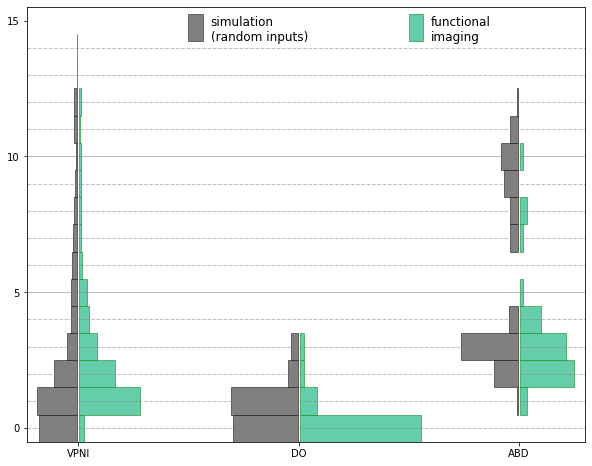

In [29]:
plt.figure(1,(10,8))

# model slopes from simulation
compare_khist([lb_slopes_sim,np.reshape(fi_slopes,(Nexp,1))],[lb_cdf,fi_cdf],['simulation\n(random inputs)','functional\nimaging'],spacing=0.75,gap=0.007)
plt.xlim(0.4,4.2)
# model slopes from leading eigenvector
#compare_khist([np.reshape(lb_slopes,(N,1)),np.reshape(fi_slopes,(Nexp,1))],[lb_cdf,fi_cdf],['leading\neigenvector','functional\nimaging'],spacing=0.75)

#plt.savefig('plots/kvalues_compare_imaging_simulation.pdf',dpi=500,transparent=True)

<h1> Comparison to Functional Imaging - Dynamics </h1>

In [15]:
stas = scipy.io.loadmat('data/STA_EMCA.mat')
abdm_mask = (stas['CellProps'][0][0][5][:,0] > 0)
abdi_mask = (stas['CellProps'][0][0][6][:,0] > 0)
vest_mask = (stas['CellProps'][0][0][7][:,0] > 0)
int_mask = ((abdm_mask + abdi_mask + vest_mask) == 0)
stas2 = np.zeros((12,635))
baseline = np.zeros(635)
for i in range(635):
    if stas['STA'][0][0][0][97,i] > stas['STA'][0][0][1][97,i]:
        stas2[:,i] = stas['STA'][0][0][0][97:109,i]
        baseline[i] = np.mean(stas['STA'][0][0][0][75:80,i])
    else:
        stas2[:,i] = stas['STA'][0][0][1][97:109,i]
        baseline[i] = np.mean(stas['STA'][0][0][1][75:80,i])
stas_adj = stas2 - np.outer(np.ones(12),baseline) # 2-6 seconds post-saccade, adjusted for pre-saccade baseline

In [33]:
def simulate(W_in,ynew=0.99,tau=0.1,customInput=False,v_in=None,x=0):
    W = copy.deepcopy(W_in)
    #W[:,flag] = 0
    #W[flag,:] = 0
    y,v = sorted_eigs(W)
    #W[:,flag] = 0
    #W[flag,:] = 0
    #vL = np.linalg.pinv(v)
    n0 = np.sum(np.real(y) > 0)
    ymax = np.max(np.real(y))
    W = ynew*W/ymax
    #y,v2 = sorted_eigs(W)
    #print(y[0])
    #for i in range(3):
    #    print(np.dot(np.real(v[:,i]),np.real(v2[:,i])))
    N = np.shape(W)[0]
    #print(np.sum((abs(np.real(v[:,0])) > 5e-2) & (abs(np.real(v[:,1])) > 5e-2)))
    #print(v[538,0:3])
    if not customInput:
        #o = np.imag(y).argsort()
        #v_in = np.real(np.sum(v[:,x:x+1],axis=1)) + np.imag(np.sum(v[:,x:x+1],axis=1))
        v_in = 0.1*abs(np.random.randn(N))
        v_in += np.real(np.sum(v[:,0:1],axis=1)) + np.imag(np.sum(v[:,0:1],axis=1))
        v_in += 1*np.real(np.sum(v[:,1:3],axis=1)) + np.imag(np.sum(v[:,1:3],axis=1))
        #v_in[538] = 0
        #v_in += 20*(np.real(np.sum(v[:,1:3],axis=1)) + np.imag(np.sum(v[:,1:3],axis=1)))
        #theta = 2*math.pi*np.random.rand()
        #v_in += 4*(np.cos(theta)*np.real(v[:,o[0]]) + np.sin(theta)*np.imag(v[:,o[0]]))
        #v_in += np.real(v[:,1]) + 0.1*(np.cos(theta)*np.real(v[:,o[1]]) + np.sin(theta)*np.imag(v[:,o[1]]))
        #v_in = 10*np.real(vL[0,:]) - np.real(vL[1,:])
        #v_in = 0.05*abs(np.random.randn(N)) + np.real(v[:,0])
    v_in = v_in / np.linalg.norm(v_in)
    input_filter = 0.001*np.exp(-np.linspace(0,10,101))
    I = np.zeros(7000)
    I[995:1005] = 1e5
    I = np.convolve(I,input_filter)[0:7000]
    r = np.zeros((7000,N))
    dt = 0.001
    for i in range(1,7000):
        r[i,:] = r[i-1,:] + dt*(np.dot(W,r[i-1,:]) - r[i-1,:] + I[i-1]*v_in)/tau
        #r = r * (r > 0)
    return r[3333::333,:]

In [60]:
my_v_in = 0.1*abs(np.random.randn(N))
y,v1 = sorted_eigs(lb_Wnorm)
my_v_in1 = 1*my_v_in + np.real(np.sum(v1[:,0:1],axis=1))# + np.imag(np.sum(v1[:,0:1],axis=1))
my_v_in1 += 1*np.real(np.sum(v1[:,1:3],axis=1))# + np.imag(np.sum(v1[:,1:2],axis=1))
lb_rates = simulate(lb_Wnorm,ynew=0.9,tau=1.0,customInput=True,v_in=my_v_in1)
#my_v_in1 = 1*my_v_in + np.real(np.sum(v1[:,0:1],axis=1))# + np.imag(np.sum(v1[:,0:1],axis=1))
#my_v_in1 += 0.5*np.real(np.sum(v1[:,1:2],axis=1)) + 1.5*np.real(np.sum(v1[:,2:3],axis=1))# + np.imag(np.sum(v1[:,1:2],axis=1))
#lb_rates2 = simulate(lb_Wnorm,ynew=0.9,tau=1.0,customInput=True,v_in=my_v_in1)
#lb_rates = np.concatenate([lb_rates,lb_rates2],axis=0)
y_scaled = 0.95 * y / np.real(y[0])
print(1.0/(1.0 - y_scaled[0]),1.0/(1.0 - y_scaled[1]))
Wprime = copy.deepcopy(lb_Wnorm)
Wprime[:,flag] = 0
Wprime[flag,:] = 0
y,v2 = sorted_eigs(Wprime)
for i in range(3):
    if np.dot(np.real(v1[:,i]),np.real(v2[:,i])) < 0:
        v2[:,i] = -v2[:,i]
my_v_in2 = my_v_in + np.real(np.sum(v2[:,0:1],axis=1)) + np.imag(np.sum(v2[:,0:1],axis=1))
my_v_in2 += 1*np.real(np.sum(v2[:,1:3],axis=1)) + np.imag(np.sum(v2[:,1:3],axis=1))
lb_rates2 = simulate(Wprime,ynew=0.9,tau=1.0,customInput=True,v_in=my_v_in2)

(19.999999999999982+0j) (2.2473347952088334+0j)


In [20]:
cell_filter = (cellIDs == 'ABD_m') | (cellIDs == 'ABD_i') | (cellIDs == '_Int_') # | (lbid ==1)

In [21]:
def fit_2exp_fixed_tau(stas,tau1=10,tau2=3):
    T,N = np.shape(stas)
    t = np.linspace(0,(T-1)*0.333333,T)
    A = np.zeros((T,2))
    A[:,0] = np.exp(-t/tau1)
    A[:,1] = np.exp(-t/tau2)
    coefs = np.zeros((N,2))
    lb = np.array([0,-999])
    ub = np.array([999,999])
    for i in range(N):
        b = stas[:,i]
        res = scipy.optimize.lsq_linear(A,b,method='trf',bounds=(lb,ub))
        coefs[i,:] = res.x[:]
    return coefs

In [45]:
coefs_im = fit_2exp_fixed_tau(stas_adj,10,4)
coefs_cn = fit_2exp_fixed_tau(lb_rates,10,4)
sf1_im = 1.0/np.std(coefs_im[:,0])
sf1_cn = 1.0/np.std(coefs_cn[cell_filter,0])
sf2_im = 1.0#/np.std(coefs_im[:,1])
sf2_cn = 1.0#/np.std(coefs_cn[:,1])
coefs_im = coefs_im*sf1_im
coefs_cn = coefs_cn*sf1_cn
#coefs_exp = np.zeros((609,2))
#coefs_exp[:,0] = v[:,0]*np.dot(lb_rates[0,:],vL[0,:])
#coefs_exp[:,1] = v[:,1]*np.dot(lb_rates[0,:],vL[1,:])
#sf1_exp = 1.0/np.std(coefs_exp[cell_filter,0])
#coefs_exp = coefs_exp*sf1_exp

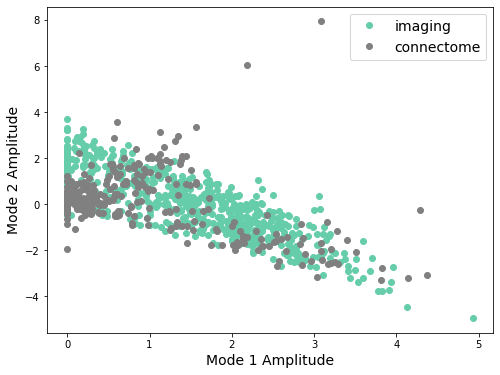

In [46]:
plt.figure(1,(8,6))
plt.plot(coefs_im[:,0],coefs_im[:,1],'o',label='imaging',color='mediumaquamarine')
plt.plot(coefs_cn[cell_filter,0],coefs_cn[cell_filter,1],'o',label='connectome',color='gray')
#plt.plot(coefs_cn[flag,0],coefs_cn[flag,1],'o',label='least central',color='orange')
plt.xlabel('Mode 1 Amplitude',fontsize=14)
plt.ylabel('Mode 2 Amplitude',fontsize=14)
plt.legend(fontsize=14)
#plt.savefig('plots/double_exponential_fit.pdf',dpi=300,transparent=True)

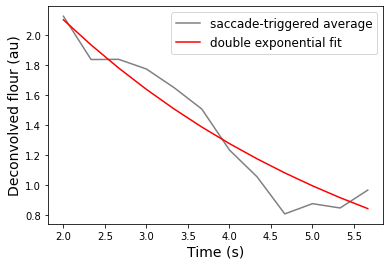

In [28]:
T = np.shape(stas_adj)[0]
t = np.linspace(2,2+(T-1)*0.333333,T)
nindex = 5
plt.plot(t,stas_adj[:,nindex],label='saccade-triggered average',color='gray')
plt.plot(t,coefs_im[nindex,0]*np.exp(-(t-2)/10)/sf1_im + coefs_im[nindex,1]*np.exp(-(t-2)/4)/sf1_im,label='double exponential fit',color='red')
plt.xlabel('Time (s)',fontsize=14)
plt.ylabel('Deconvolved flour (au)',fontsize=14)
plt.legend(fontsize=12)
#plt.savefig('plots/connectome_paper/plots_requested0708/double_exponential_fit_example_trace.pdf',dpi=300,transparent=True)

(0.85, 1.01)

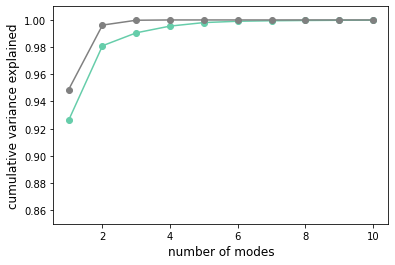

In [22]:
u_im,s_im,v_im = np.linalg.svd(stas_adj)
u_cn,s_cn,v_cn = np.linalg.svd(lb_rates[:,cell_filter])
cv_im = s_im[:10]**2/np.sum(s_im**2)
cv_cn = s_cn[:10]**2/np.sum(s_cn**2)
for i in range(1,10):
    cv_im[i] += cv_im[i-1]
    cv_cn[i] += cv_cn[i-1]
plt.plot(np.linspace(1,10,10),cv_im,'o-',color='mediumaquamarine',label='imaging')
plt.plot(np.linspace(1,10,10),cv_cn,'o-',color='gray',label='connectome')
plt.xlabel('number of modes',fontsize=12)
plt.ylabel('cumulative variance explained',fontsize=12)
plt.ylim(0.85,1.01)
#plt.savefig('plots/cumulative_variance_explained.pdf',dpi=300,transparent=True)

In [18]:
def simulate_series(W_in,ymax,v_in,ynew=0.99,tau=0.1):
    W = copy.deepcopy(W_in)
    W = ynew*W/ymax
    N = np.shape(W)[0]
    input_filter = 0.001*np.exp(-np.linspace(0,10,101))
    I1 = np.zeros(7000)
    I1[995:1005] = 1e5
    I1 = np.convolve(I1,input_filter)[0:7000]
    I = np.zeros(21000)
    I[0:7000] = I1[:]
    I[7000:14000] = I1[:]
    I[14000:21000] = I1[:]
    r = np.zeros((21000,N))
    dt = 0.001
    positions = np.ones((36,2))
    positions[12:24,0] = 2
    positions[24:,0] = 3
    responses = np.ones((36,N))
    for i in range(1,21000):
        r[i,:] = r[i-1,:] + dt*(np.dot(W,r[i-1,:]) - r[i-1,:] + I[i-1]*v_in)/tau
    return r

In [61]:
y,v1 = sorted_eigs(lb_Wnorm)
my_v_in1 = 0.1*abs(np.random.randn(N)) + np.real(np.sum(v1[:,0:1],axis=1))# + np.imag(np.sum(v1[:,0:1],axis=1))
my_v_in1 += 1*np.real(np.sum(v1[:,1:3],axis=1))# + np.imag(np.sum(v1[:,1:2],axis=1))
lb_rates = simulate_series(W_in=lb_Wnorm,ymax=np.real(y[0]),v_in=my_v_in1,ynew=0.9,tau=1.0)

In [62]:
norm_rates = copy.deepcopy(lb_rates)
for i in range(N):
    if np.max(abs(norm_rates[:7000,i])) > 0:
        norm_rates[:,i] = norm_rates[:,i] / np.max(abs(norm_rates[:7000,i]))

271


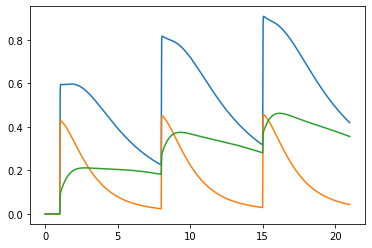

In [63]:
t = np.linspace(0,21,21000)
print(np.argmax(norm_rates[6900,:]))
plt.plot(t,lb_rates[:,272])
plt.plot(t,lb_rates[:,273])
plt.plot(t,lb_rates[:,281])
#plt.savefig('plots/simulated_rates.pdf',transparent=True,dpi=500)

<h1> Synapse Detection Jitter </h1>

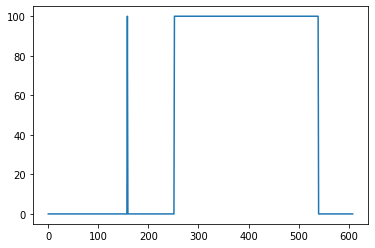

In [177]:
sameCluster2 = np.zeros((N,N))
diffCluster2 = np.zeros((N,N))
sameCluster7 = np.zeros((N,N))
diffCluster7 = np.zeros((N,N))
modOPercentage = np.zeros(N)
njitters = 100
eigvals = np.zeros((N,njitters),np.complex128)
jslopes = np.zeros((N,njitters))
jcoefs_cn = np.zeros((N,2,njitters))
jcv_cn = np.zeros((10,njitters))
y,v1 = sorted_eigs(lb_Wnorm)
for i in range(1,101):
    # Must run jitter.py to populate these first!
    f = open(f'data/jitter_{i}.data','rb')
    data = pickle.load(f)
    f.close
    modOPercentage[data['modO'] == 1] += 1
    for j in range(3):
        sameCluster2[np.ix_(data['2 Block SBM'] == j,data['2 Block SBM'] == j)] += 1
    for j in range(8):
        sameCluster7[np.ix_(data['7 Block SBM'] == j,data['7 Block SBM'] == j)] += 1
    jWnorm = data['connMat']
    for j in range(N):
        if data['totalInputs'][j] > 0:
            jWnorm[j,:] = jWnorm[j,:] / data['totalInputs'][j]
    jWnorm = final_adjustments(jWnorm,lb_cdf)
    y,v2 = sorted_eigs(jWnorm)
    eigvals[:,i-1] = y[:] / np.real(y[0])
    #eigvals[:,i-1] = data['eigenvalues'] / np.real(data['eigenvalues'][0])
    jslopes[:,i-1] = data['slopes']
    for j in range(3):
        if np.dot(np.real(v1[:,j]),np.real(v2[:,j])) < 0:
            v2[:,j] = -v2[:,j]
    my_v_in = 0.1*abs(np.random.randn(N)) + np.real(np.sum(v2[:,0:1],axis=1)) + np.imag(np.sum(v2[:,0:1],axis=1))
    my_v_in += 1*np.real(np.sum(v2[:,1:3],axis=1)) + np.imag(np.sum(v2[:,1:3],axis=1))
    lb_rates = simulate(jWnorm,ynew=0.9,tau=1,customInput=True,v_in=my_v_in)
    coefs_cn = fit_2exp_fixed_tau(lb_rates,10,4)
    sf1_cn = 1.0/np.std(coefs_cn[cell_filter,0])
    jcoefs_cn[:,:,i-1] = coefs_cn*sf1_cn
    u_cn,s_cn,v_cn = np.linalg.svd(lb_rates[:,cell_filter])
    cv_cn = s_cn[:10]**2/np.sum(s_cn**2)
    for j in range(1,10):
        cv_cn[j] += cv_cn[j-1]
    jcv_cn[:,i-1] = cv_cn[:]
plt.plot(modOPercentage)

68


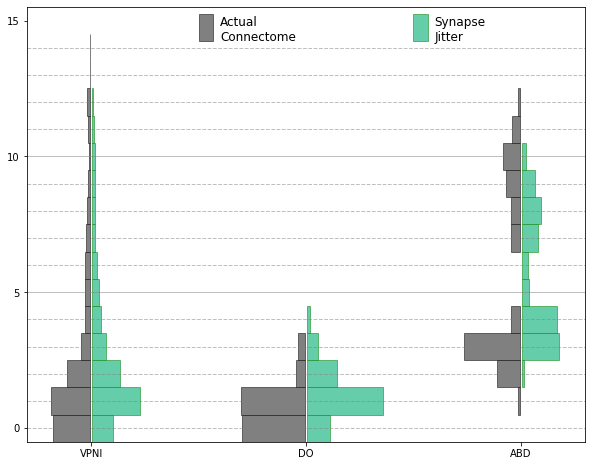

In [158]:
plt.figure(1,(10,8))
# model slopes from simulation
compare_khist([lb_slopes_sim,jslopes],[lb_cdf,lb_cdf],['Actual\nConnectome','Synapse\nJitter'],spacing=0.75,gap=0.007)
plt.xlim(0.3,4.2)
#plt.savefig('plots/synapse_jitter_slopes.pdf',transparent=True,dpi=500)

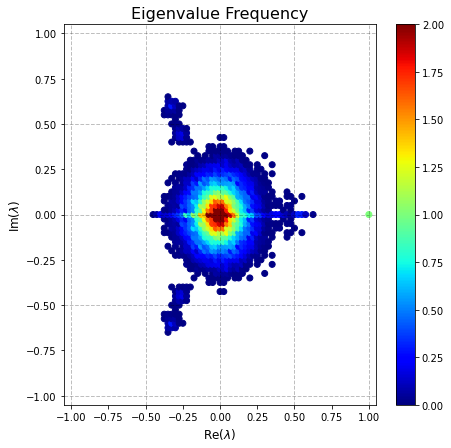

In [130]:
plt.figure(1,(7,7))
plot_eig_frequency(eigvals,'Eigenvalue Frequency',nbins=83)
#plt.savefig('plots/synpase_jitter_eigenvalues.pdf',dpi=500,transparent=True)

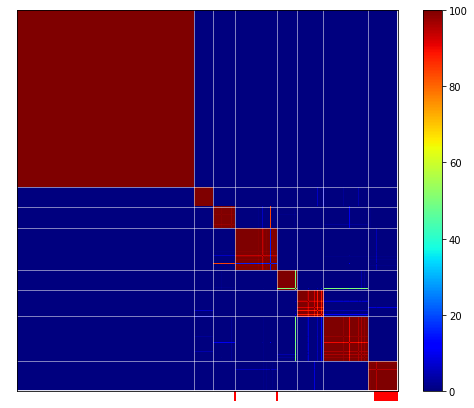

In [135]:
pltbid = copy.deepcopy(sbmid7)
nmod = 7
pltbid[cellIDs == 'vSPNs'] = 100
pltbid[cellIDs == 'ABD_m'] = 101
pltbid[cellIDs == 'ABD_i'] = 102
#pltbid[pltbid == 99] = 8
#pltbid[pltbid == 3] = 5
#pltbid[pltbid == 4] = 3
#pltbid[pltbid == 2] = 4
#pltbid[pltbid == 99] = 2
#pltbid[pltbid == 6] = 99
#pltbid[pltbid == 7] = 6
#pltbid[pltbid == 99] = 7
N_axial = int(np.sum(pltbid == 0))
N_om = np.zeros(12,dtype=np.int32)
N_om[0] = np.sum(pltbid == 1)
N_om[1] = np.sum(pltbid == 2)
N_om[2] = np.sum(pltbid == 3)
N_om[3] = np.sum(pltbid == 4)
N_om[4] = np.sum(pltbid == 5)
N_om[5] = np.sum(pltbid == 6)
N_om[6] = np.sum(pltbid == 7)
N_om[7] = np.sum(pltbid == 8)
N_om[8] = np.sum(pltbid == 9)
N_om[9] = np.sum(pltbid == 10)
N_om[10] = np.sum(pltbid == 11)
N_om[11] = np.sum(pltbid == 12)
N_vspn = np.sum(pltbid == 100)
N_abdm = np.sum(pltbid == 101)
N_abdi = np.sum(pltbid == 102)
N_abd = N_abdm + N_abdi
blockOrder = pltbid.argsort()
A_sorted = []
W_sorted = []
x_a = []
y_a = []
x_w = []
y_w = []
do_ticks = []
dotl = []
#om1 = np.where(pltbid == 1)[0]
newOrder = np.sum(-lb_Wnorm[np.ix_(pltbid > 99,blockOrder[:N_axial])],axis=0).argsort()
blockOrder[:N_axial] = blockOrder[:N_axial][newOrder]
lb_Wnorm[np.ix_(pltbid > 100,cellIDs == '_DOs_')] -= 1
for i in range(nmod):
    beg = int(N_axial + np.sum(N_om[0:i]))
    end = int(beg + N_om[i])
    newOrder = np.sum(-lb_Wnorm[np.ix_(pltbid > 100,blockOrder[beg:end])],axis=0).argsort()
    blockOrder[beg:end] = blockOrder[beg:end][newOrder]
lb_Wnorm[np.ix_(pltbid > 100,cellIDs == '_DOs_')] += 1
for j in range(N):
    if sbm_cdf.loc['vest'][blockOrder[j]]:
        do_ticks.append(j)
        dotl.append('')

#plt.figure(1,(2.6,2))
plt.figure(1,(9,7))
#cmap = ListedColormap(["navy", "blue", "lightseagreen","lawngreen","gold","darkorange","magenta","red"])
cmap = ListedColormap(["blue",'cyan',"green",'springgreen',"gold",'orange','purple',"magenta","red",'darkred'])
#plt.scatter(x_a,y_a,c=A_sorted,cmap=cmap,vmax=5,s=4)
# TO PLOT BLOCK AVERAGES, COMMENT OUT LINE ABOVE AND UNCOMMENT LINE BELOW
#plt.imshow(A[np.ix_(blockOrder[::-1],blockOrder)],cmap=cmap,vmin=0.0,vmax=0.5)
plt.imshow(reorder(sameCluster7,blockOrder),cmap='jet',interpolation='None')
plt.colorbar()
lw = 0.5
for i in range(10):
    plt.axvline(np.sum(pltbid < i+1)-0.5,color='white',linewidth=lw)
    plt.axhline(np.sum(pltbid < i+1)-0.5,color='white',linewidth=lw)
#plt.axvline(np.sum(pltbid < 100)-0.5,color='black',linewidth=lw)
#plt.axhline(N-np.sum(pltbid < 100)-0.5,color='black',linewidth=lw)
#plt.axvline(np.sum(pltbid < 101)-0.5,color='black',linewidth=lw)
#plt.axhline(N-np.sum(pltbid < 101)-0.5,color='black',linewidth=lw)
#plt.axvline(np.sum(pltbid < 102)-0.5,color='black',linewidth=lw)
#plt.axhline(N-np.sum(pltbid < 102)-0.5,color='black',linewidth=lw)
#cycle_color='orange'
#plt.axvline(np.sum(pltbid < 3)+0.5,(N-np.sum(pltbid < 5)-0.5)/(N),(N-np.sum(pltbid < 4)-0.5)/(N),color=cycle_color,linewidth=lw*8)
#plt.axvline(np.sum(pltbid < 4)-0.5,(N-np.sum(pltbid < 5)-0.5)/(N),(N-np.sum(pltbid < 4)-0.5)/(N),color=cycle_color,linewidth=lw*8)
#plt.axhline(N-np.sum(pltbid < 4)-0.5,(np.sum(pltbid < 3)+0.5)/(N-N_abd-N_vspn),(np.sum(pltbid < 4)-0.5)/(N-N_abd-N_vspn),color=cycle_color,linewidth=lw*8)
#plt.axhline(N-np.sum(pltbid < 5)-0.5,(np.sum(pltbid < 3)+0.5)/(N-N_abd-N_vspn),(np.sum(pltbid < 4)-0.5)/(N-N_abd-N_vspn),color=cycle_color,linewidth=lw*8)
#plt.axvline(np.sum(pltbid < 4)+0.5,(N-np.sum(pltbid < 6)-0.5)/(N),(N-np.sum(pltbid < 5)-0.5)/(N),color=cycle_color,linewidth=lw*8)
#plt.axvline(np.sum(pltbid < 5)-0.5,(N-np.sum(pltbid < 6)-0.5)/(N),(N-np.sum(pltbid < 5)-0.5)/(N),color=cycle_color,linewidth=lw*8)
#plt.axhline(N-np.sum(pltbid < 5)-0.5,(np.sum(pltbid < 4)+0.5)/(N-N_abd-N_vspn),(np.sum(pltbid < 5)-0.5)/(N-N_abd-N_vspn),color=cycle_color,linewidth=lw*8)
#plt.axhline(N-np.sum(pltbid < 6)-0.5,(np.sum(pltbid < 4)+0.5)/(N-N_abd-N_vspn),(np.sum(pltbid < 5)-0.5)/(N-N_abd-N_vspn),color=cycle_color,linewidth=lw*8)
#plt.axvline(np.sum(pltbid < 5)+0.5,(N-np.sum(pltbid < 4)-0.5)/(N),(N-np.sum(pltbid < 3)-0.5)/(N),color=cycle_color,linewidth=lw*8)
#plt.axvline(np.sum(pltbid < 6)-0.5,(N-np.sum(pltbid < 4)-0.5)/(N),(N-np.sum(pltbid < 3)-0.5)/(N),color=cycle_color,linewidth=lw*8)
#plt.axhline(N-np.sum(pltbid < 3)-0.5,(np.sum(pltbid < 5)+0.5)/(N-N_abd-N_vspn),(np.sum(pltbid < 6)-0.5)/(N-N_abd-N_vspn),color=cycle_color,linewidth=lw*8)
#plt.axhline(N-np.sum(pltbid < 4)-0.5,(np.sum(pltbid < 5)+0.5)/(N-N_abd-N_vspn),(np.sum(pltbid < 6)-0.5)/(N-N_abd-N_vspn),color=cycle_color,linewidth=lw*8)
#cycle_color='darkviolet'
#plt.axvline(np.sum(pltbid < 6)+0.5,(N-np.sum(pltbid < 8)-0.5)/(N),(N-np.sum(pltbid < 7)-0.5)/(N),color=cycle_color,linewidth=lw*8)
#plt.axvline(np.sum(pltbid < 7)-0.5,(N-np.sum(pltbid < 8)-0.5)/(N),(N-np.sum(pltbid < 7)-0.5)/(N),color=cycle_color,linewidth=lw*8)
#plt.axhline(N-np.sum(pltbid < 7)-0.5,(np.sum(pltbid < 6)+0.5)/(N-N_abd-N_vspn),(np.sum(pltbid < 7)-0.5)/(N-N_abd-N_vspn),color=cycle_color,linewidth=lw*8)
#plt.axhline(N-np.sum(pltbid < 8)-0.5,(np.sum(pltbid < 6)+0.5)/(N-N_abd-N_vspn),(np.sum(pltbid < 7)-0.5)/(N-N_abd-N_vspn),color=cycle_color,linewidth=lw*8)
#plt.axvline(np.sum(pltbid < 7)+0.5,(N-np.sum(pltbid < 9)-0.5)/(N),(N-np.sum(pltbid < 8)-0.5)/(N),color=cycle_color,linewidth=lw*8)
#plt.axvline(np.sum(pltbid < 8)-0.5,(N-np.sum(pltbid < 9)-0.5)/(N),(N-np.sum(pltbid < 8)-0.5)/(N),color=cycle_color,linewidth=lw*8)
#plt.axhline(N-np.sum(pltbid < 8)-0.5,(np.sum(pltbid < 7)+0.5)/(N-N_abd-N_vspn),(np.sum(pltbid < 8)-0.5)/(N-N_abd-N_vspn),color=cycle_color,linewidth=lw*8)
#plt.axhline(N-np.sum(pltbid < 9)-0.5,(np.sum(pltbid < 7)+0.5)/(N-N_abd-N_vspn),(np.sum(pltbid < 8)-0.5)/(N-N_abd-N_vspn),color=cycle_color,linewidth=lw*8)
#plt.axvline(np.sum(pltbid < 8)+0.5,(N-np.sum(pltbid < 7)-0.5)/(N),(N-np.sum(pltbid < 6)-0.5)/(N),color=cycle_color,linewidth=lw*8)
#plt.axvline(np.sum(pltbid < 9)-0.5,(N-np.sum(pltbid < 7)-0.5)/(N),(N-np.sum(pltbid < 6)-0.5)/(N),color=cycle_color,linewidth=lw*8)
#plt.axhline(N-np.sum(pltbid < 6)-0.5,(np.sum(pltbid < 8)+0.5)/(N-N_abd-N_vspn),(np.sum(pltbid < 9)-0.5)/(N-N_abd-N_vspn),color=cycle_color,linewidth=lw*8)
#plt.axhline(N-np.sum(pltbid < 7)-0.5,(np.sum(pltbid < 8)+0.5)/(N-N_abd-N_vspn),(np.sum(pltbid < 9)-0.5)/(N-N_abd-N_vspn),color=cycle_color,linewidth=lw*8)

plt.xlim(0,N-N_abd-N_vspn)
#plt.ylim(N_axial-1,N)
plt.ylim(N-N_abd-N_vspn,0)
xticks = []
yticks = []
xticklabels = []
yticklabels = []
for i in range(nmod):
    xticks.append(N_axial + np.sum(N_om[0:i]) + N_om[i]/2)
    yticks.append(N - (N_axial + np.sum(N_om[0:i]) + N_om[i]/2))
    xticklabels.append('O_{0:d}'.format(i+1,))
    yticklabels.append('O_{0:d} (N = {1:d})'.format(i+1,int(N_om[i])))
xticks.append(N_axial + np.sum(N_om) + N_vspn + N_abd/2)
xticklabels.append('ABD')
yticks.append(N - (N_axial + np.sum(N_om) + N_vspn + N_abdm/2))
yticklabels.append('ABDM (N = {0:d})'.format(N_abdm))
yticks.append(N - (N_axial + np.sum(N_om) + N_vspn + N_abdm + N_abdi/2))
yticklabels.append('ABDI (N = {0:d})'.format(N_abdi))
#plt.xticks(xticks,xticklabels,fontsize=5)
#plt.yticks(yticks,yticklabels,fontsize=5)
plt.xticks(do_ticks,dotl)
plt.yticks([],[])
ax = plt.gca()
ax.tick_params(colors='red',length=10,width=2)
#plt.savefig('plots/synapse_jitter_association_matrix_SBM7.pdf',dpi=500,transparent=True)

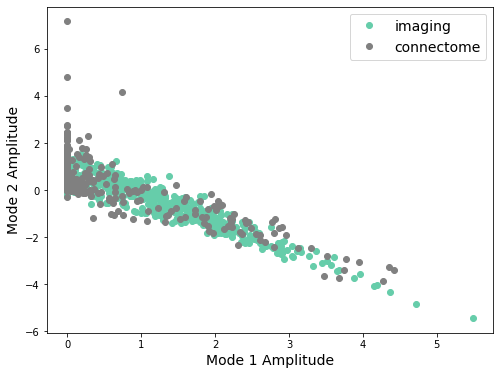

In [444]:
plt.figure(1,(8,6))
plt.plot(coefs_im[:,0],coefs_im[:,1],'o',label='imaging',color='mediumaquamarine')
plt.plot(jcoefs_cn[cell_filter,0,3],jcoefs_cn[cell_filter,1,3],'o',label='connectome',color='gray')
plt.xlabel('Mode 1 Amplitude',fontsize=14)
plt.ylabel('Mode 2 Amplitude',fontsize=14)
plt.legend(fontsize=14)
#plt.savefig('plots/double_exponential_fit_tau1s_input3_synapse_jitter.pdf',dpi=300,transparent=True)

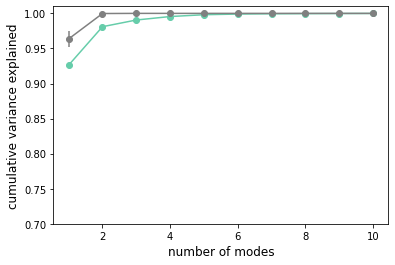

In [179]:
plt.plot(np.linspace(1,10,10),cv_im,'o-',color='mediumaquamarine',label='imaging')
plt.errorbar(np.linspace(1,10,10),np.mean(jcv_cn,axis=1),yerr=np.std(jcv_cn,axis=1),fmt='o-',color='gray',label='connectome')
plt.xlabel('number of modes',fontsize=12)
plt.ylabel('cumulative variance explained',fontsize=12)
plt.ylim(0.7,1.01)
#plt.savefig('plots/cumulative_variance_explained_input3_synapse_jitter.pdf',dpi=300,transparent=True)

<h1> 3 Axial Blocks and 7 OM Blocks </h1>

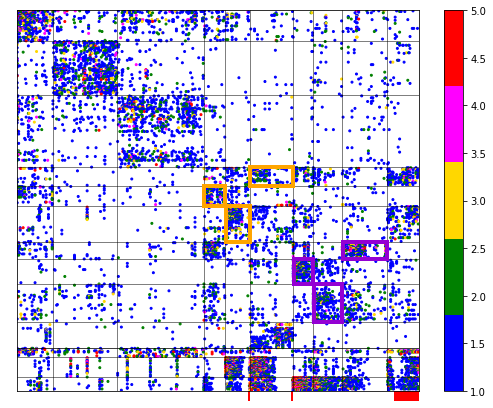

In [32]:
# plot weight matrices with and without normalization with specified block structure
pltbid = copy.deepcopy(sbmid_3_7)
pltbid[cellIDs == 'vSPNs'] = 100
pltbid[cellIDs == 'ABD_m'] = 101
pltbid[cellIDs == 'ABD_i'] = 102
pltbid[pltbid == 3] = 99
pltbid[pltbid == 6] = 3
pltbid[pltbid == 8] = 6
pltbid[pltbid == 7] = 8
pltbid[pltbid == 4] = 7
pltbid[pltbid == 99] = 4
pltbid[pltbid == 5] = 99
pltbid[pltbid == 9] = 5
pltbid[pltbid == 99] = 9
#pltbid[pltbid == 99] = 8
#pltbid[pltbid == 3] = 5
#pltbid[pltbid == 4] = 3
#pltbid[pltbid == 2] = 4
#pltbid[pltbid == 99] = 2
#pltbid[pltbid == 6] = 99
#pltbid[pltbid == 7] = 6
#pltbid[pltbid == 99] = 7
N_am = np.zeros(3,dtype=np.int32)
N_am[0] = np.sum(pltbid == 0)
N_am[1] = np.sum(pltbid == 1)
N_am[2] = np.sum(pltbid == 2)
N_axial = int(np.sum(N_am))
N_om = np.zeros(12,dtype=np.int32)
N_om[0] = np.sum(pltbid == 3)
N_om[1] = np.sum(pltbid == 4)
N_om[2] = np.sum(pltbid == 5)
N_om[3] = np.sum(pltbid == 6)
N_om[4] = np.sum(pltbid == 7)
N_om[5] = np.sum(pltbid == 8)
N_om[6] = np.sum(pltbid == 9)
N_om[7] = np.sum(pltbid == 10)
N_om[8] = np.sum(pltbid == 11)
N_om[9] = np.sum(pltbid == 12)
N_om[10] = np.sum(pltbid == 13)
N_om[11] = np.sum(pltbid == 14)
N_vspn = np.sum(pltbid == 100)
N_abdm = np.sum(pltbid == 101)
N_abdi = np.sum(pltbid == 102)
N_abd = N_abdm + N_abdi
blockOrder = pltbid.argsort()
A_sorted = []
W_sorted = []
x_a = []
y_a = []
x_w = []
y_w = []
do_ticks = []
dotl = []
#om1 = np.where(pltbid == 1)[0]
for i in range(3):
    beg = int(np.sum(N_am[0:i]))
    end = int(beg + N_am[i])
    newOrder = np.sum(-lb_Wnorm[np.ix_(pltbid > 99,blockOrder[beg:end])],axis=0).argsort()
    blockOrder[beg:end] = blockOrder[beg:end][newOrder]
lb_Wnorm[np.ix_(pltbid > 100,cellIDs == '_DOs_')] -= 1
for i in range(7):
    beg = int(N_axial + np.sum(N_om[0:i]))
    end = int(beg + N_om[i])
    newOrder = np.sum(-lb_Wnorm[np.ix_(pltbid > 100,blockOrder[beg:end])],axis=0).argsort()
    blockOrder[beg:end] = blockOrder[beg:end][newOrder]
lb_Wnorm[np.ix_(pltbid > 100,cellIDs == '_DOs_')] += 1
for j in range(N):
    if sbm_cdf.loc['vest'][blockOrder[j]]:
        do_ticks.append(j)
        dotl.append('')
A = copy.deepcopy(connMat)
for i in range(10):
    for j in range(10):
        A[np.ix_(pltbid==i,pltbid==j)] = np.mean(A[np.ix_(pltbid==i,pltbid==j)])
    A[np.ix_(pltbid==100,pltbid==i)] = np.mean(A[np.ix_(pltbid==100,pltbid==i)])
    A[np.ix_(pltbid==101,pltbid==i)] = np.mean(A[np.ix_(pltbid==101,pltbid==i)])
    A[np.ix_(pltbid==102,pltbid==i)] = np.mean(A[np.ix_(pltbid==102,pltbid==i)])
for i in range(N):
    for j in range(N):
        if connMat[blockOrder[i],blockOrder[j]] > 0:
            #if pltbid[blockOrder[i]] != 100:
            y_a.append(N-1-i)
            x_a.append(j)
            A_sorted.append(connMat[blockOrder[i],blockOrder[j]])
y_w = np.array(y_w,dtype=np.int32)
x_w = np.array(x_w,dtype=np.int32)
W_sorted = np.array(W_sorted)
#print(W_sorted[(pltbid[blockOrder[x_w]] == 1) & (pltbid[blockOrder[N - 1 - y_w]] == 1)])
#print(pltbid[(N-1) - y_w[:N_om[0]]])
#print(pltbid[x_w[:N_om[0]]])

#plt.figure(1,(2.6,2))
plt.figure(1,(9,7))
#cmap = ListedColormap(["navy", "blue", "lightseagreen","lawngreen","gold","darkorange","magenta","red"])
cmap = ListedColormap(["blue","green","gold","magenta","red"])
plt.scatter(x_a,y_a,c=A_sorted,cmap=cmap,vmax=5,s=4)
# TO PLOT BLOCK AVERAGES, COMMENT OUT LINE ABOVE AND UNCOMMENT LINE BELOW
#plt.imshow(A[np.ix_(blockOrder[::-1],blockOrder)],cmap=cmap,vmin=0.0,vmax=0.5)
plt.colorbar()
lw = 0.5
for i in range(10):
    plt.axvline(np.sum(pltbid < i+1)-0.5,color='black',linewidth=lw)
    plt.axhline(N-np.sum(pltbid < i+1)-0.5,color='black',linewidth=lw)
plt.axvline(np.sum(pltbid < 100)-0.5,color='black',linewidth=lw)
plt.axhline(N-np.sum(pltbid < 100)-0.5,color='black',linewidth=lw)
plt.axvline(np.sum(pltbid < 101)-0.5,color='black',linewidth=lw)
plt.axhline(N-np.sum(pltbid < 101)-0.5,color='black',linewidth=lw)
#plt.axvline(np.sum(pltbid < 102)-0.5,color='black',linewidth=lw)
plt.axhline(N-np.sum(pltbid < 102)-0.5,color='black',linewidth=lw)
cycle_color='orange'
plt.axvline(np.sum(pltbid < 3)+0.5,(N-np.sum(pltbid < 5)-0.5)/(N),(N-np.sum(pltbid < 4)-0.5)/(N),color=cycle_color,linewidth=lw*8)
plt.axvline(np.sum(pltbid < 4)-0.5,(N-np.sum(pltbid < 5)-0.5)/(N),(N-np.sum(pltbid < 4)-0.5)/(N),color=cycle_color,linewidth=lw*8)
plt.axhline(N-np.sum(pltbid < 4)-0.5,(np.sum(pltbid < 3)+0.5)/(N-N_abd-N_vspn),(np.sum(pltbid < 4)-0.5)/(N-N_abd-N_vspn),color=cycle_color,linewidth=lw*8)
plt.axhline(N-np.sum(pltbid < 5)-0.5,(np.sum(pltbid < 3)+0.5)/(N-N_abd-N_vspn),(np.sum(pltbid < 4)-0.5)/(N-N_abd-N_vspn),color=cycle_color,linewidth=lw*8)
plt.axvline(np.sum(pltbid < 4)+0.5,(N-np.sum(pltbid < 6)-0.5)/(N),(N-np.sum(pltbid < 5)-0.5)/(N),color=cycle_color,linewidth=lw*8)
plt.axvline(np.sum(pltbid < 5)-0.5,(N-np.sum(pltbid < 6)-0.5)/(N),(N-np.sum(pltbid < 5)-0.5)/(N),color=cycle_color,linewidth=lw*8)
plt.axhline(N-np.sum(pltbid < 5)-0.5,(np.sum(pltbid < 4)+0.5)/(N-N_abd-N_vspn),(np.sum(pltbid < 5)-0.5)/(N-N_abd-N_vspn),color=cycle_color,linewidth=lw*8)
plt.axhline(N-np.sum(pltbid < 6)-0.5,(np.sum(pltbid < 4)+0.5)/(N-N_abd-N_vspn),(np.sum(pltbid < 5)-0.5)/(N-N_abd-N_vspn),color=cycle_color,linewidth=lw*8)
plt.axvline(np.sum(pltbid < 5)+0.5,(N-np.sum(pltbid < 4)-0.5)/(N),(N-np.sum(pltbid < 3)-0.5)/(N),color=cycle_color,linewidth=lw*8)
plt.axvline(np.sum(pltbid < 6)-0.5,(N-np.sum(pltbid < 4)-0.5)/(N),(N-np.sum(pltbid < 3)-0.5)/(N),color=cycle_color,linewidth=lw*8)
plt.axhline(N-np.sum(pltbid < 3)-0.5,(np.sum(pltbid < 5)+0.5)/(N-N_abd-N_vspn),(np.sum(pltbid < 6)-0.5)/(N-N_abd-N_vspn),color=cycle_color,linewidth=lw*8)
plt.axhline(N-np.sum(pltbid < 4)-0.5,(np.sum(pltbid < 5)+0.5)/(N-N_abd-N_vspn),(np.sum(pltbid < 6)-0.5)/(N-N_abd-N_vspn),color=cycle_color,linewidth=lw*8)
cycle_color='darkviolet'
plt.axvline(np.sum(pltbid < 6)+0.5,(N-np.sum(pltbid < 8)-0.5)/(N),(N-np.sum(pltbid < 7)-0.5)/(N),color=cycle_color,linewidth=lw*8)
plt.axvline(np.sum(pltbid < 7)-0.5,(N-np.sum(pltbid < 8)-0.5)/(N),(N-np.sum(pltbid < 7)-0.5)/(N),color=cycle_color,linewidth=lw*8)
plt.axhline(N-np.sum(pltbid < 7)-0.5,(np.sum(pltbid < 6)+0.5)/(N-N_abd-N_vspn),(np.sum(pltbid < 7)-0.5)/(N-N_abd-N_vspn),color=cycle_color,linewidth=lw*8)
plt.axhline(N-np.sum(pltbid < 8)-0.5,(np.sum(pltbid < 6)+0.5)/(N-N_abd-N_vspn),(np.sum(pltbid < 7)-0.5)/(N-N_abd-N_vspn),color=cycle_color,linewidth=lw*8)
plt.axvline(np.sum(pltbid < 7)+0.5,(N-np.sum(pltbid < 9)-0.5)/(N),(N-np.sum(pltbid < 8)-0.5)/(N),color=cycle_color,linewidth=lw*8)
plt.axvline(np.sum(pltbid < 8)-0.5,(N-np.sum(pltbid < 9)-0.5)/(N),(N-np.sum(pltbid < 8)-0.5)/(N),color=cycle_color,linewidth=lw*8)
plt.axhline(N-np.sum(pltbid < 8)-0.5,(np.sum(pltbid < 7)+0.5)/(N-N_abd-N_vspn),(np.sum(pltbid < 8)-0.5)/(N-N_abd-N_vspn),color=cycle_color,linewidth=lw*8)
plt.axhline(N-np.sum(pltbid < 9)-0.5,(np.sum(pltbid < 7)+0.5)/(N-N_abd-N_vspn),(np.sum(pltbid < 8)-0.5)/(N-N_abd-N_vspn),color=cycle_color,linewidth=lw*8)
plt.axvline(np.sum(pltbid < 8)+0.5,(N-np.sum(pltbid < 7)-0.5)/(N),(N-np.sum(pltbid < 6)-0.5)/(N),color=cycle_color,linewidth=lw*8)
plt.axvline(np.sum(pltbid < 9)-0.5,(N-np.sum(pltbid < 7)-0.5)/(N),(N-np.sum(pltbid < 6)-0.5)/(N),color=cycle_color,linewidth=lw*8)
plt.axhline(N-np.sum(pltbid < 6)-0.5,(np.sum(pltbid < 8)+0.5)/(N-N_abd-N_vspn),(np.sum(pltbid < 9)-0.5)/(N-N_abd-N_vspn),color=cycle_color,linewidth=lw*8)
plt.axhline(N-np.sum(pltbid < 7)-0.5,(np.sum(pltbid < 8)+0.5)/(N-N_abd-N_vspn),(np.sum(pltbid < 9)-0.5)/(N-N_abd-N_vspn),color=cycle_color,linewidth=lw*8)

plt.xlim(0,N-N_abd-N_vspn)
#plt.ylim(N_axial-1,N)
plt.ylim(0,N)
xticks = []
yticks = []
xticklabels = []
yticklabels = []
for i in range(3):
    xticks.append(np.sum(N_am[0:i]) + N_am[i]/2)
    yticks.append(N - (np.sum(N_am[0:i]) + N_am[i]/2))
    xticklabels.append('A_{0:d}'.format(i+1,))
    yticklabels.append('A_{0:d} (N = {1:d})'.format(i+1,int(N_am[i])))
for i in range(7):
    xticks.append(N_axial + np.sum(N_om[0:i]) + N_om[i]/2)
    yticks.append(N - (N_axial + np.sum(N_om[0:i]) + N_om[i]/2))
    xticklabels.append('O_{0:d}'.format(i+1,))
    yticklabels.append('O_{0:d} (N = {1:d})'.format(i+1,int(N_om[i])))
xticks.append(N_axial + np.sum(N_om) + N_vspn + N_abd/2)
xticklabels.append('ABD')
yticks.append(N - (N_axial + np.sum(N_om) + N_vspn + N_abdm/2))
yticklabels.append('ABDM (N = {0:d})'.format(N_abdm))
yticks.append(N - (N_axial + np.sum(N_om) + N_vspn + N_abdm + N_abdi/2))
yticklabels.append('ABDI (N = {0:d})'.format(N_abdi))
#plt.xticks(xticks,xticklabels,fontsize=5)
#plt.yticks(yticks,yticklabels,fontsize=5)
plt.xticks(do_ticks,dotl)
plt.yticks([],[])
ax = plt.gca()
ax.tick_params(colors='red',length=10,width=2)
#plt.savefig('plots/adjacency_SBM_3+7block_raw_connectome.pdf',dpi=500,transparent=True)

<h1> Random Matrices </h1>

[1.19206883+0.j         0.3584755 +0.j         0.34509581+0.11822405j]


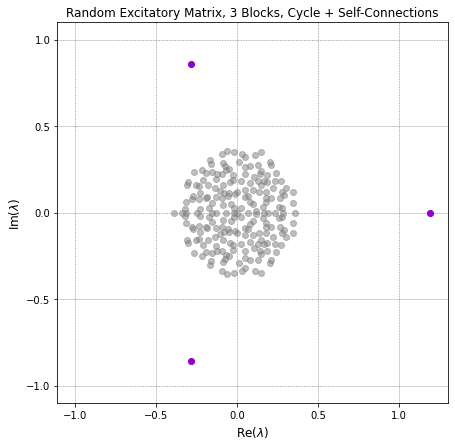

In [185]:
prob = 0.1
n = 210
n3 = int(n/3)
#W = np.zeros((n,n))
#W[n3:2*n3,:n3] = np.ones((n3,n3))/(n3*prob) * (np.random.rand(n3,n3) < prob)
#W[2*n3:,n3:2*n3] = np.ones((n3,n3))/(n3*prob) * (np.random.rand(n3,n3) < prob)
#W[:n3,2*n3:] = np.ones((n3,n3))/(n3*prob) * (np.random.rand(n3,n3) < prob)
#W[:n3,:n3] = 0.2*np.ones((n3,n3))/(n3*prob) * (np.random.rand(n3,n3) < prob)
#W[n3:2*n3,n3:2*n3] = 0.2*np.ones((n3,n3))/(n3*prob) * (np.random.rand(n3,n3) < prob)
#W[2*n3:,2*n3:] = 0.2*np.ones((n3,n3))/(n3*prob) * (np.random.rand(n3,n3) < prob)

y,v = sorted_eigs(W)
#eig_sf = 1.0 / abs(y[0])
print(y[0:3])
plt.figure(1,(7,7))
plt.axvline(-1.0,color='black',linestyle='--',linewidth=0.5,alpha=0.5)
plt.axvline(-0.5,color='black',linestyle='--',linewidth=0.5,alpha=0.5)
plt.axvline(0.0,color='black',linestyle='--',linewidth=0.5,alpha=0.5)
plt.axvline(0.5,color='black',linestyle='--',linewidth=0.5,alpha=0.5)
plt.axvline(1.0,color='black',linestyle='--',linewidth=0.5,alpha=0.5)
plt.axhline(-1.0,color='black',linestyle='--',linewidth=0.5,alpha=0.5)
plt.axhline(-0.5,color='black',linestyle='--',linewidth=0.5,alpha=0.5)
plt.axhline(0.0,color='black',linestyle='--',linewidth=0.5,alpha=0.5)
plt.axhline(0.5,color='black',linestyle='--',linewidth=0.5,alpha=0.5)
plt.axhline(1.0,color='black',linestyle='--',linewidth=0.5,alpha=0.5)
y_1 = np.array([y[0],y[-12],y[-13]],dtype=np.complex128)
#y_2 = np.array([y[1]],dtype=np.complex128)
#y_3 = y[2:3]
plt.plot(np.real(y),np.imag(y),'o',color='grey',alpha=0.5,label='unperturbed network')
plt.plot(np.real(y_1),np.imag(y_1),'o',color='darkviolet')
#plt.plot(np.real(y_2),np.imag(y_2),'o',color='orange')
#plt.plot(np.real(y_3),np.imag(y_3),'o',color='green')
plt.xticks([-1.0,-0.5,0.0,0.5,1.0])
plt.yticks([-1.0,-0.5,0.0,0.5,1.0])
plt.xlabel('Re($\\lambda$)',fontsize=12)
plt.ylabel('Im($\\lambda$)',fontsize=12)
plt.title('Random Excitatory Matrix, 3 Blocks, Cycle + Self-Connections')
#plt.savefig('plots/eigenvalues_random_matrix_3blocks_cycle_plus_self_connections.pdf',dpi=500,transparent=True)

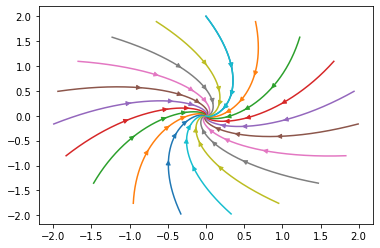

In [4]:
def add_arrow(line, position, direction='right', size=15, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    start_ind = position
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="-|>", color=color),
        size=size
    )

def get_trajectory(eta,w,theta,t,tau=1):
    x = 2*np.exp((eta-1)*t/tau)*(np.cos(theta)*np.cos(w*t/tau) - np.sin(theta)*np.sin(w*t/tau))
    y = -2*np.exp((eta-1)*t/tau)*(np.cos(theta)*np.sin(w*t/tau) + np.sin(theta)*np.cos(w*t/tau))
    return x,y

y,v = sorted_eigs(lb_Wnorm)
y = y / np.real(y[0])
#print(y[-5:])
eta = np.real(y[-3])
w = np.imag(y[-3])
t = np.linspace(0,5,5001)
t2 = np.linspace(0.5,4.5,9)
for theta in np.linspace(-math.pi/2,3*math.pi/2,20):#[-math.pi/2,-math.pi/3,-math.pi/4,-math.pi/6,0,math.pi/4,math.pi/2]:
    xr,xm = get_trajectory(eta,w,theta,t)
    line, = plt.plot(xr,xm)
    add_arrow(line,500,size=10)
    add_arrow(line,1000,size=10)
    add_arrow(line,1500,size=10)
    #x,y = get_trajectory(eta,w,theta,t2)
    #plt.plot(x,y,'o',markersize=2)
#plt.xlabel('time (multiples of $\\tau$)')
#plt.savefig('plots/complex_mode_curves.pdf',dpi=500,transparent=True)